# Предсказание социально-демографических характеристик пользователей Rutube
    Пользователи RUTUBE не всегда указывают свои данные, такие как возраст и пол, что затрудняет формирование портрета пользователя и создание персонализированных рекомендаций. Это ограничивает возможности платформы в предоставлении контента, который наиболее подходит интересам и потребностям пользователей, тем самым ухудшая пользовательский опыт.

    Необходимо разработать модель, которая на основе истории просмотров сможет предсказывать пол и возраст пользователя. В качестве baseline решения мы предоставляем этот ноутбук.


In [52]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

from catboost import CatBoostClassifier, CatBoostRegressor, Pool

from tqdm.auto import trange, tqdm

import collections
from collections import Counter
from collections import defaultdict

from scipy.stats import entropy
from scipy.stats import linregress

from functools import reduce

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Устанавливаем тему по умолчанию
sb_dark = sns.dark_palette('skyblue', 8, reverse=True) # teal
sns.set(palette=sb_dark)

In [3]:
# Настройки
# Убираем ограничение отображемых колонок
pd.set_option("display.max_columns", None)

# Загружаем данные

In [4]:
%%time
path = "datasets/" # Ваш путь до директории с данными /path/to/data/
data = pd.read_csv(path + 'train_events.csv')
video = pd.read_csv(path + 'video_info_v2.csv')
targets = pd.read_csv(path + 'train_targets.csv')
all_events = pd.read_csv(path + 'all_events.csv')

# заполянем пропуски самыми частотными
freq_ua_client_type = all_events['ua_client_type'].value_counts().index[0]
freq_ua_client_name = all_events['ua_client_name'].value_counts().index[0]
all_events['ua_client_type'] = all_events['ua_client_type'].fillna(freq_ua_client_type)
all_events['ua_client_name'] = all_events['ua_client_name'].fillna(freq_ua_client_name)
all_events['ua_os'] = all_events['ua_os'].fillna('vpn')
data['ua_os'] = data['ua_os'].fillna('vpn')

# Преобразование даты и время в тип даты
all_events['event_timestamp'] = pd.to_datetime(all_events['event_timestamp'])
data['event_timestamp'] = pd.to_datetime(data['event_timestamp'])

# продолжительность видео duration - указан в миллисекнудах, а просмотр человеком (total_watchtime) в секндах приводим к одному виду
# video['duration'] = video['duration']/1000
all_events['total_watchtime'] = all_events['total_watchtime'] * 1000
data['total_watchtime'] = data['total_watchtime'] * 1000

data.shape, video.shape, targets.shape, all_events.shape

CPU times: total: 58.1 s
Wall time: 58.5 s


((1759616, 9), (481480, 5), (180012, 4), (8439624, 9))

In [5]:
%%time
# Заменяем опечатки в регионах и заодно сводим области и города в один регион
region_name_replace = {
    'Astrakhan Oblast': 'Astrakhan',
    'Arkhangelsk Oblast': 'Arkhangelskaya',
    'Ivanovo Oblast': 'Ivanovo', 
    'Kaliningrad Oblast': 'Kaliningrad',
    'Kaluga Oblast': 'Kaluga',
    'Kirov Oblast': 'Kirov',
    'Krasnodar Krai': 'Krasnodarskiy',
    'Krasnoyarsk Krai': 'Krasnoyarskiy',
    'Kursk Oblast': 'Kursk',
    'Omsk Oblast': 'Omsk',
    'Orel Oblast': 'Oryol oblast',
    'Penza Oblast':'Penza', 
    'Perm Krai': 'Perm',
    'Primorskiy (Maritime) Kray': 'Primorye',
    'Ryazan Oblast': 'Rostov',
    'Saratovskaya Oblast': 'Saratov Oblast',
    'Smolensk Oblast': 'Smolensk',
    'Smolenskaya Oblast': 'Smolensk',
    'Smolenskaya Oblast’': 'Smolensk',
    'Stavropol Kray': 'Stavropol Krai',
    'Stavropol’ Kray': 'Stavropol Krai',
    'Sverdlovsk Oblast': 'Sverdlovsk',
    'Tambov Oblast': 'Tambov',
    'Tula Oblast': 'Tula',
    'Tver’ Oblast': 'Tver Oblast',
    'Tyumen’ Oblast': 'Tyumen Oblast',
    'Vladimir Oblast': 'Vladimir',
    'Vologda Oblast': 'Vologda',
    'Voronezh Oblast': 'Voronezj',
    "Leningradskaya Oblast'": 'Leningradskaya Oblast',
}

all_events['region'] = all_events['region'].replace(region_name_replace)
data['region'] = data['region'].replace(region_name_replace)

all_events['region'].unique().shape, data['region'].unique().shape

CPU times: total: 6.69 s
Wall time: 6.71 s


((88,), (88,))

In [6]:
# Пример смещений для регионов (в часах относительно московского времени)
region_timezone_offset = {
    'Adygeya Republic': 0,
    'Altai': +4,
    'Altay Kray': +4,
    'Amur Oblast': +6,
    'Arkhangelskaya': 0,
    'Astrakhan': 0,
    'Bashkortostan Republic': +2,
    'Belgorod Oblast': 0,
    'Bryansk Oblast': 0,
    'Buryatiya Republic': +5,
    'Chechnya': 0,
    'Chelyabinsk': +2,
    'Chukotka': +9,
    'Chuvashia': 0,
    'Crimea': 0,
    'Dagestan': 0,
    'Ingushetiya Republic': 0,
    'Irkutsk Oblast': +5,
    'Ivanovo': 0,
    'Jaroslavl': 0,
    'Jewish Autonomous Oblast': +5,
    'Kabardino-Balkariya Republic': 0,
    'Kaliningrad': -1,
    'Kalmykiya Republic': 0,
    'Kaluga': 0,
    'Kamchatka': +9,
    'Karachayevo-Cherkesiya Republic': 0,
    'Karelia': 0,
    'Kemerovo Oblast': +4,
    'Khabarovsk': +6,
    'Khakasiya Republic': +4,
    'Khanty-Mansia': +2,
    'Kirov': 0,
    'Komi': 0,
    'Kostroma Oblast': 0,
    'Krasnodarskiy': 0,
    'Krasnoyarskiy': +4,
    'Kurgan Oblast': +2,
    'Kursk': 0,
    'Kuzbass': +4,
    'Leningradskaya Oblast': 0,
    'Lipetsk Oblast': 0,
    'Magadan Oblast': +8,
    'Mariy-El Republic': 0,
    'Mordoviya Republic': 0,
    'Moscow': 0,
    'Moscow Oblast': 0,
    'Murmansk': 0,
    'Nenets': 0,
    'Nizhny Novgorod Oblast': 0,
    'North Ossetia': 0,
    'North Ossetia–Alania': 0,
    'Novgorod Oblast': 0,
    'Novosibirsk Oblast': +4,
    'Omsk': +3,
    'Orenburg Oblast': +2,
    'Oryol oblast': 0,
    'Penza': 0,
    'Perm': +2,
    'Primorye': +7,
    'Pskov Oblast': 0,
    'Rostov': 0,
    'Sakha': +6,
    'Sakhalin Oblast': +8,
    'Samara Oblast': +1,
    'Saratov Oblast': +1,
    'Sebastopol City': 0,
    'Smolensk': 0,
    'St.-Petersburg': 0,
    'Stavropol Krai': 0,
    'Sverdlovsk': +2,
    'Tambov': 0,
    'Tatarstan Republic': 0,
    'Tomsk Oblast': +4,
    'Transbaikal Territory': +5,
    'Tula': 0,
    'Tver Oblast': 0,
    'Tyumen Oblast': +2,
    'Tyva Republic': +4,
    'Udmurtiya Republic': +2,
    'Ulyanovsk': 0,
    'Vladimir': 0,
    'Volgograd Oblast': 0,
    'Vologda': 0,
    'Voronezj': 0,
    'Yamalo-Nenets': +2,
    'Yaroslavl Oblast': 0,
    'Zabaykalskiy (Transbaikal) Kray': +6,
}

In [7]:
%%time
# Добавляем смещение в зависимости от региона
def change_time_by_region(df:pd.DataFrame):
    df['time_offset'] = df['region'].map(region_timezone_offset)
    # Обновляем время в зависимости от смещения
    df['event_timestamp'] = df['event_timestamp'] + pd.to_timedelta(df['time_offset'], unit='h')
    return df
all_events = change_time_by_region(all_events)
data = change_time_by_region(data)

CPU times: total: 1.03 s
Wall time: 1.04 s


In [8]:
%%time
from sklearn.model_selection import train_test_split

train_users_df, test_users_df = train_test_split(targets, stratify=(targets[['age_class', 'sex']]), test_size=0.1)
# train_users_df.shape, test_users_df.shape

data_video = data.merge(video, on='rutube_video_id')
train_users_df = data_video.merge(train_users_df, on='viewer_uid')
test_users_df = data_video.merge(test_users_df, on='viewer_uid')
del data_video

train_users_df.shape, test_users_df.shape

CPU times: total: 2.03 s
Wall time: 2.06 s


((1581980, 17), (177636, 17))

In [9]:
# Файл для сабмита
# submit_test_users_df = pd.read_csv('Dima/sample_10000.csv')
submit_test_users_df = pd.read_csv('test_dataset/test_events.csv')
submit_test_users_df = submit_test_users_df.merge(video, on='rutube_video_id')
submit_test_users_df.shape

(587735, 13)

In [10]:
submit_test_users_df['ua_os'] = submit_test_users_df['ua_os'].fillna('vpn')

# Преобразование даты и время в тип даты
submit_test_users_df['event_timestamp'] = pd.to_datetime(submit_test_users_df['event_timestamp'])

# продолжительность видео duration - указан в миллисекнудах, а просмотр человеком (total_watchtime) в секндах приводим к одному виду
submit_test_users_df['total_watchtime'] = submit_test_users_df['total_watchtime'] * 1000

submit_test_users_df['region'] = submit_test_users_df['region'].replace(region_name_replace)
submit_test_users_df = change_time_by_region(submit_test_users_df)

submit_test_users_df.shape

(587735, 14)

In [12]:
# all_users_df = pd.concat([train_users_df, test_users_df])
# all_users_df.shape

# Feature Engineering

In [13]:
#  train_users_df['event_timestamp']

In [14]:
# Фичи по дате 
def datetime_features(df:pd.DataFrame, datetime_col:str):
    # Преобразоывавем в датавремя
    # df['event_timestamp'] = pd.to_datetime(df['event_timestamp'])
    # df.info()
    # Базовые временные признаки
    # df['year'] = df['datetime'].dt.year № 
    # df['month'] = df['datetime'].dt.month
    df['day'] = df[datetime_col].dt.day
    df['hour'] = df[datetime_col].dt.hour
    # df['minute'] = df['datetime'].dt.minute
    # df['second'] = df['datetime'].dt.second
    # День недели (0 - понедельник, 6 - воскресенье)
    df['dayofweek'] = df[datetime_col].dt.dayofweek

    # Название дня недели
    df['day_name'] = df[datetime_col].dt.day_name()

    # Выходной день (суббота или воскресенье)
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    # Неделя года
    df['weekofyear'] = df[datetime_col].dt.isocalendar().week
    # Время суток (утро, день, вечер, ночь)
    df['time_of_day'] = pd.cut(df['hour'], 
                               bins=[-1, 6, 12, 18, 24], 
                               labels=['ночь', 'утро', 'день', 'вечер'])

    # Рабочее время (с 9 до 18)
    df['is_business_hours'] = ((df['hour'] >= 9) & (df['hour'] < 18) & (~df['is_weekend'])).astype(int)

    # Синусоидальное представление времени суток
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

    # Синусоидальное представление дня недели
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    
    return df

train_users_df = datetime_features(df=train_users_df, datetime_col='event_timestamp')
test_users_df = datetime_features(df=test_users_df, datetime_col='event_timestamp') 

submit_test_users_df = datetime_features(df=submit_test_users_df, datetime_col='event_timestamp') 

train_users_df.shape, test_users_df.shape

((1581980, 29), (177636, 29))

In [15]:
def feature_preprocessing(df):
    # Переводим ИД видео в число
    df['video_id'] = df['rutube_video_id'].apply(lambda x: int(x[6:]))

    # Частотное кодирование
    no_frequency_columns = ['region', 'ua_device_type', 'ua_client_type','ua_os', 'ua_client_name', 'rutube_video_id', 'viewer_uid', 'title', 'category', 'author_id']
    for col_name in no_frequency_columns:
        df[f'frequency_{col_name}'] = df[col_name].map(df[col_name].value_counts(normalize=True))
        
    return df
train_users_df = feature_preprocessing(train_users_df)
test_users_df = feature_preprocessing(test_users_df)
submit_test_users_df = feature_preprocessing(submit_test_users_df)


train_users_df.shape, test_users_df.shape


((1581980, 40), (177636, 40))

In [16]:
%%time
# Фичи на базе длинны просмотров
def duration_features(df:pd.DataFrame):
    # Человек суммарно по времени просмотраивал видео больше чем длится само видео
    df['is_few_views'] = df['total_watchtime'] > df['duration']
    # Eсть датафрейм df с колонками 'duration' и 'total_watchtime'
    # Убедимся, что эти колонки имеют числовой тип данных
    # df['duration'] = pd.to_numeric(df['duration'], errors='coerce')
    # df['total_watchtime'] = pd.to_numeric(df['total_watchtime'], errors='coerce')

    # 1. Процент просмотренного видео
    df['watch_percentage'] = (df['total_watchtime'] / df['duration']).clip(0, 1) * 100
    df['watch_percentage_all'] = (df['total_watchtime'] / df['duration']) * 100

    # 2. Категории вовлеченности
    df['engagement_category'] = pd.cut(df['watch_percentage'], 
                                       bins=[0, 25, 50, 75, 100],
                                       labels=['Низкая', 'Средняя', 'Высокая', 'Полная'])

    # 3. Флаг полного просмотра
    df['watched_completely'] = (df['watch_percentage'] >= 95).astype(int)

    # 4. Флаг просмотра более половины
    df['watched_more_than_half'] = (df['watch_percentage'] > 50).astype(int)

    # 5. Оставшееся время просмотра
    df['remaining_time'] = df['duration'] - df['total_watchtime']

    # 6. Логарифм времени просмотра (полезно для длинных видео)
    df['log_watchtime'] = np.log1p(df['total_watchtime'])

    # 7. Отношение времени просмотра к средней длительности всех видео
    mean_duration = df['duration'].mean()
    df['relative_watch_time'] = df['total_watchtime'] / mean_duration

    # 8. Z-score времени просмотра
    df['watchtime_zscore'] = (df['total_watchtime'] - df['total_watchtime'].mean()) / df['total_watchtime'].std()

    # 9. Категории длительности видео
    df['duration_category'] = pd.qcut(df['duration'], q=4, labels=['Короткое', 'Средне-короткое', 'Средне-длинное', 'Длинное'])

    # 10. Флаг аномального просмотра (например, более 150% длительности видео)
    df['abnormal_viewing'] = (df['watch_percentage'] > 150).astype(int)

    # 11. Скорость просмотра (предполагая, что пользователь мог смотреть видео на повышенной скорости)
    df['viewing_speed'] = df['total_watchtime'] / df['duration']

    # 12. Отклонение от ожидаемого времени просмотра
    df['watch_time_deviation'] = df['total_watchtime'] - (df['duration'] * 0.5)  # предполагаем, что в среднем смотрят половину видео

    # 13. Ранг видео по времени просмотра
    df['watch_time_rank'] = df['total_watchtime'].rank(method='dense', ascending=False)

    # 14. Интервалы просмотра
    df['watch_interval'] = pd.cut(df['total_watchtime'], 
                                  bins=[0, 60, 300, 900, 1800, np.inf],
                                  labels=['<1 мин', '1-5 мин', '5-15 мин', '15-30 мин', '>30 мин'])

    # 15. Эффективность просмотра (отношение процента просмотра к длительности)
    df['viewing_efficiency'] = df['watch_percentage'] / df['duration']

    # 16. Флаг "зацепившего" видео (просмотрено более 80% при длительности более 5 минут)
    df['engaging_video'] = ((df['watch_percentage'] > 80) & (df['duration'] > 300)).astype(int)

    # 17. Кумулятивная сумма времени просмотра (предполагая, что данные отсортированы по пользователю и времени)
    df['cumulative_watch_time'] = df.groupby('viewer_uid')['total_watchtime'].cumsum()

    # 18. Время с начала сессии до начала просмотра (если есть данные о времени начала просмотра)
    # df['time_before_watch'] = df['watch_start_time'] - df.groupby('session_id')['watch_start_time'].transform('min')

    # 19. Энтропия просмотров пользователя (разнообразие длительности просмотренных видео)
    df['watch_time_entropy'] = df.groupby('viewer_uid')['total_watchtime'].transform(lambda x: -np.sum((x/x.sum()) * np.log2(x/x.sum())))

    # 20. Тренд просмотров пользователя (увеличение или уменьшение времени просмотра)
#     def safe_trend(x):
#         try:
#             return np.polyfit(range(len(x)), x, 1)[0]
#         except np.linalg.LinAlgError:
#             return np.nan

#     df['watch_time_trend'] = df.groupby('viewer_uid')['total_watchtime'].transform(safe_trend)
    def safe_trend(x):
        if len(x) < 2:  
            return 0
        try:
            return np.polyfit(range(len(x)), x, 1)[0]
        except (np.linalg.LinAlgError, TypeError, ValueError):
            return 0

    df['watch_time_trend'] = df.groupby('viewer_uid')['total_watchtime'].transform(safe_trend)
    # df['watch_time_trend'] = df.groupby('viewer_uid')['total_watchtime'].transform(lambda x: np.polyfit(range(len(x)), x, 1)[0])

    return df

train_users_df = duration_features(train_users_df)
test_users_df = duration_features(test_users_df)
submit_test_users_df = duration_features(submit_test_users_df)

train_users_df.shape, test_users_df.shape

CPU times: total: 1min 13s
Wall time: 1min 13s


((1581980, 61), (177636, 61))

In [17]:
submit_test_users_df.shape

(587735, 58)

In [18]:
# submit_test_users_df.isna().sum().max()

In [19]:
# train_users_df['viewer_uid'].to_csv('train_viewer_uid_v2.csv')
# test_users_df['viewer_uid'].to_csv('test_viewer_uid_v2.csv')

# Статистика по обезличенным фактам просмотрам видео 

Генерим более умные фичи на базе обсуждений и то что в итоге отразим в презентации

Для этого используем общую известную статистику просмотров по абсолютно всем пользователям

In [20]:
# Для расчета статистик объяединяем все события по просмотрам неизвестных пользоватлеей с событиями известных
union_all_events = pd.concat([all_events, data])
union_all_events = union_all_events.merge(video, on='rutube_video_id')
union_all_events.shape

(10199240, 14)

In [21]:
%%time
def video_statistic_features(df:pd.DataFrame, union_all_events:pd.DataFrame):
    # Вычисление популярности видео, авторов и категорий в union_all_events
    # Популярность видео
    video_popularity = union_all_events.groupby('rutube_video_id').agg(
        video_view_count=('viewer_uid', 'count'),
        video_avg_watchtime=('total_watchtime', 'mean')
    ).reset_index()

    # Популярность авторов
    author_popularity = union_all_events.groupby('author_id').agg(
        author_view_count=('viewer_uid', 'count'),
        author_avg_watchtime=('total_watchtime', 'mean')
    ).reset_index()

    # Популярность категорий
    category_popularity = union_all_events.groupby('category').agg(
        category_view_count=('viewer_uid', 'count'),
        category_avg_watchtime=('total_watchtime', 'mean')
    ).reset_index()

    # Обогащение df информацией о популярности:
    # Объединяем df с популярностью видео
    df = df.merge(video_popularity, on='rutube_video_id', how='left')
    # Объединяем df с популярностью авторов
    df = df.merge(author_popularity, on='author_id', how='left')
    # Объединяем df с популярностью категорий
    df = df.merge(category_popularity, on='category', how='left')

    
    # Группируем данные по пользователю
    user_features = df.groupby('viewer_uid').agg(
        total_videos_watched=('rutube_video_id', 'count'),
        total_watchtime=('total_watchtime', 'sum'),
        avg_watchtime=('total_watchtime', 'mean'),
        unique_categories=('category', 'nunique'),
        unique_authors=('author_id', 'nunique'),
        most_common_device=('ua_device_type', lambda x: x.mode()[0]),
        most_common_os=('ua_os', lambda x: x.mode()[0]),
        most_common_browser=('ua_client_name', lambda x: x.mode()[0]),
        avg_video_popularity=('video_view_count', 'mean'),
        avg_author_popularity=('author_view_count', 'mean'),
        avg_category_popularity=('category_view_count', 'mean'),
        watchtime_ratio=('total_watchtime', lambda x: x.sum() / df.loc[x.index, 'duration'].sum())
    ).reset_index()
    user_features = user_features.rename(columns={'total_watchtime': 'total_watchtime_user_feat'})
    
    df = df.merge(user_features, on='viewer_uid')
    
    # Вычисляем наиболее частые часы и дни недели для каждого пользователя
    time_features = df.groupby('viewer_uid').agg(
        most_common_hour=('hour', lambda x: x.mode()[0]),
        most_common_weekday=('dayofweek', lambda x: x.mode()[0])
    ).reset_index()

    # Объединяем с df
    df = df.merge(time_features, on='viewer_uid', how='left')

    def category_entropy(categories):
        counts = categories.value_counts()
        return entropy(counts)

    category_entropy_df = df.groupby('viewer_uid').agg(
        category_entropy=('category', category_entropy)
    ).reset_index()

    # Объединяем с user_features
    df = df.merge(category_entropy_df, on='viewer_uid', how='left')
    
    # Вычисление сессий пользователя:
    # Сортируем по пользователю и времени
    df = df.sort_values(by=['viewer_uid', 'event_timestamp'])

    # Вычисляем разницу во времени между событиями
    df['time_diff'] = df.groupby('viewer_uid')['event_timestamp'].diff().dt.total_seconds()

    # Если разница больше 30 минут, начинаем новую сессию
    df['new_session'] = (df['time_diff'] > 1800).fillna(0).astype(int)

    # Нумеруем сессии
    df['session_id'] = df.groupby('viewer_uid')['new_session'].cumsum()

    # Вычисляем статистики по сессиям
    session_features = df.groupby(['viewer_uid', 'session_id']).agg(
        session_watchtime=('total_watchtime', 'sum')
    ).reset_index()

    session_stats = session_features.groupby('viewer_uid').agg(
        total_sessions=('session_id', 'nunique'),
        avg_session_watchtime=('session_watchtime', 'mean')
    ).reset_index()

    # # Объединяем с user_features
    df = df.merge(session_stats, on='viewer_uid', how='left')

    # Региональные предпочтения пользователя
    # Популярность видео по регионам
    video_region_popularity = union_all_events.groupby(['rutube_video_id', 'region']).agg(
        region_view_count=('viewer_uid', 'count')
    ).reset_index()

    # Определяем самый популярный регион для каждого видео
    video_top_region = video_region_popularity.loc[video_region_popularity.groupby('rutube_video_id')['region_view_count'].idxmax()].rename(columns={'region': 'top_region'})


    # Объединяем с df
    df = df.merge(video_top_region[['rutube_video_id', 'top_region']], on='rutube_video_id', how='left')

    # Проверяем совпадение региона пользователя с популярным регионом видео
    df['region_match'] = (df['region'] == df['top_region']).astype(int)

    # Вычисляем долю совпадений для каждого пользователя
    region_match_df = df.groupby('viewer_uid').agg(
        region_match_ratio=('region_match', 'mean')
    ).reset_index()

    # Объединяем с user_features
    df = df.merge(region_match_df, on='viewer_uid', how='left')
    
    return df
    
train_users_df = video_statistic_features(df=train_users_df, union_all_events=union_all_events)
test_users_df = video_statistic_features(df=test_users_df, union_all_events=union_all_events)
submit_test_users_df = video_statistic_features(df=submit_test_users_df, union_all_events=union_all_events)

train_users_df.shape, test_users_df.shape

CPU times: total: 2min 40s
Wall time: 2min 41s


((1581980, 90), (177636, 90))

In [22]:
submit_test_users_df.shape

(587735, 87)

In [23]:


%%time
def video_statistic_features_part_2(df:pd.DataFrame, union_all_events:pd.DataFrame):
    # Предпочтения пользователя по длительности видео
    # Средняя и стандартное отклонение длительности видео для каждого пользователя
    video_duration_stats = df.groupby('viewer_uid').agg(
        avg_video_duration=('duration', 'mean'),
        std_video_duration=('duration', 'std')
    ).reset_index()
    
    # Коэффициент завершения просмотра
    # Рассчитываем отношение времени просмотра к длительности видео для каждого события
    df['completion_rate'] = df['total_watchtime'] / (df['duration'] / 1000)  # Приводим длительность к секундам

    # Ограничиваем коэффициент от 0 до 1
    df['completion_rate'] = df['completion_rate'].clip(0, 1)

    # Средний коэффициент завершения для каждого пользователя
    user_completion_rate = df.groupby('viewer_uid').agg(
        avg_completion_rate=('completion_rate', 'mean'),
        high_completion_rate_videos=('completion_rate', lambda x: (x > 0.75).mean())
    ).reset_index()
    
    # Среднее время между событиями
    # Сортируем данные по пользователю и времени
    df = df.sort_values(by=['viewer_uid', 'event_timestamp'])

    # Вычисляем разницу во времени между событиями
    df['time_diff_seconds'] = df.groupby('viewer_uid')['event_timestamp'].diff().dt.total_seconds()

    # Среднее и стандартное отклонение времени между событиями для каждого пользователя
    user_time_diff_stats = df.groupby('viewer_uid').agg(
        avg_time_between_events=('time_diff_seconds', 'mean'),
        std_time_between_events=('time_diff_seconds', 'std')
    ).reset_index()
    
    # Предпочтения по авторам
    # Количество просмотров по каждому автору для каждого пользователя
    user_author_views = df.groupby(['viewer_uid', 'author_id']).size().reset_index(name='views')

    # Находим топ-3 авторов для каждого пользователя
    user_top_authors = user_author_views.sort_values(['viewer_uid', 'views'], ascending=[True, False]).groupby('viewer_uid').head(3)

    # Общее количество просмотров для каждого пользователя
    user_total_views = df.groupby('viewer_uid').size().reset_index(name='total_views')

    # Доля просмотров топ-3 авторов
    user_top_authors_views = user_top_authors.groupby('viewer_uid')['views'].sum().reset_index(name='top_authors_views')

    # Объединяем и вычисляем долю
    user_author_preference = user_total_views.merge(user_top_authors_views, on='viewer_uid')
    user_author_preference['top_authors_view_ratio'] = user_author_preference['top_authors_views'] / user_author_preference['total_views']
    
    # Поведение по времени суток
    # Вычисляем, является ли просмотр ночным (с 0:00 до 6:00)
    df['is_night'] = df['event_timestamp'].dt.hour.isin([0,1,2,3,4,5]).astype(int)

    # Доля ночных просмотров
    user_night_views = df.groupby('viewer_uid').agg(
        night_view_ratio=('is_night', 'mean'),
        avg_hour=('event_timestamp', lambda x: x.dt.hour.mean())
    ).reset_index()
    
    # Предпочтения по категориям
    # Количество просмотров по каждой категории для каждого пользователя
    user_category_views = df.groupby(['viewer_uid', 'category']).size().reset_index(name='views')

    # Находим топ-3 категории для каждого пользователя
    user_top_categories = user_category_views.sort_values(['viewer_uid', 'views'], ascending=[True, False]).groupby('viewer_uid').head(3)

    # Доля просмотров топ-3 категорий
    user_top_categories_views = user_top_categories.groupby('viewer_uid')['views'].sum().reset_index(name='top_categories_views')

    # Объединяем и вычисляем долю
    user_category_preference = user_total_views.merge(user_top_categories_views, on='viewer_uid')
    user_category_preference['top_categories_view_ratio'] = user_category_preference['top_categories_views'] / user_category_preference['total_views']

    # Разнообразие устройств
    # Количество уникальных устройств
    user_device_stats = df.groupby('viewer_uid').agg(
        unique_devices=('ua_device_type', 'nunique')
    ).reset_index()

    # Доля каждого типа устройства
    device_type_dummies = pd.get_dummies(df['ua_device_type'])
    df = pd.concat([df, device_type_dummies], axis=1)

    user_device_type_ratio = df.groupby('viewer_uid')[device_type_dummies.columns].mean().reset_index()
    
    # Региональное поведение
    # Количество уникальных регионов
    user_region_stats = df.groupby('viewer_uid').agg(
        unique_regions=('region', 'nunique')
    ).reset_index()
    
    # Доля просмотров из домашнего региона (предполагаем, что домашний регион - самый частый)
    user_home_region = df.groupby('viewer_uid')['region'].agg(lambda x: x.mode()[0]).reset_index(name='home_region')

    df = df.merge(user_home_region, on='viewer_uid', how='left')
    df['is_home_region'] = (df['region'] == df['home_region']).astype(int)

    user_home_region_ratio = df.groupby('viewer_uid').agg(
        home_region_view_ratio=('is_home_region', 'mean')
    ).reset_index()
    
    # Повторные просмотры
    # Количество уникальных видео, просмотренных более одного раза
    user_video_views = df.groupby(['viewer_uid', 'rutube_video_id']).size().reset_index(name='views')

    user_repeat_views = user_video_views[user_video_views['views'] > 1].groupby('viewer_uid').size().reset_index(name='repeat_videos')

    # Доля повторных просмотров
    user_repeat_views = user_repeat_views.merge(user_total_views, on='viewer_uid', how='left')
    user_repeat_views['repeat_view_ratio'] = user_repeat_views['repeat_videos'] / user_total_views['total_views']
    
    
    #  Временные тренды активности
    # Добавляем дату в формате года и недели, хотя тут нам год то и не так важен в этой задаче
    df['year_week'] = df['event_timestamp'].dt.strftime('%Y-%U')

    # Количество просмотров по неделям
    user_weekly_views = df.groupby(['viewer_uid', 'year_week']).size().reset_index(name='weekly_views')

    # Для простоты вычислим коэффициент корреляции между временем и количеством просмотров
    

    def activity_trend(views):
        if len(views) > 1:
            x = range(len(views))
            y = views.values
            slope, _, _, _, _ = linregress(x, y)
            return slope
        else:
            return 0

    user_activity_trend = user_weekly_views.groupby('viewer_uid').agg(
        activity_trend=('weekly_views', activity_trend)
    ).reset_index()

    
    #  Новизна контента
    # Получаем даты публикации видео
    video_publish_dates = union_all_events[['rutube_video_id', 'event_timestamp']].groupby('rutube_video_id').min().reset_index()
    video_publish_dates.rename(columns={'event_timestamp': 'video_publish_date'}, inplace=True)

    # Объединяем с df
    df = df.merge(video_publish_dates, on='rutube_video_id', how='left')

    # Вычисляем время с момента публикации до просмотра
    df['time_since_publish'] = (df['event_timestamp'] - df['video_publish_date']).dt.total_seconds() / 86400  # В днях

    # Среднее время с момента публикации
    user_content_novelty = df.groupby('viewer_uid').agg(
        avg_time_since_publish=('time_since_publish', 'mean'),
        new_video_view_ratio=('time_since_publish', lambda x: (x <= 7).mean())
    ).reset_index()
    
    # Моделирование последовательностей просмотров
    # Для каждого пользователя создадим последовательность категорий
    user_category_sequence = df.groupby('viewer_uid')['category'].apply(list).reset_index()

    # Можно использовать модели последовательностей, такие как Марковские цепи, для анализа
    # Здесь для простоты вычислим вероятность перехода между категориями

    transition_counts = defaultdict(lambda: defaultdict(int))
    for categories in user_category_sequence['category']:
        for i in range(len(categories) - 1):
            transition_counts[categories[i]][categories[i+1]] += 1

    # Преобразуем в вероятности
    transition_probs = {k: {k2: v2 / sum(v.values()) for k2, v2 in v.items()} for k, v in transition_counts.items()}
    
    # Скорость просмотра
    # Вычисляем общее время просмотра и количество просмотров для каждого пользователя
    user_speed = df.groupby('viewer_uid').agg(
        total_watchtime=('total_watchtime', 'sum'),
        total_views=('rutube_video_id', 'count')
    ).reset_index()

    # Скорость просмотра (время просмотра на один просмотр)
    user_speed['watch_speed'] = user_speed['total_watchtime'] / user_speed['total_views']
    
    # Удаляем типы популряных устройств, т.к. будем их отедльно добавлять
    df = df.drop(columns=['desktop', 'smartphone', 'tablet'], errors='ignore')
    
    # Объединение признаков
    # Объединяем все новые признаки
    feature_dfs = [
        video_duration_stats,
        user_completion_rate,
        user_time_diff_stats,
        user_author_preference[['viewer_uid', 'top_authors_view_ratio']],
        user_night_views,
        user_category_preference[['viewer_uid', 'top_categories_view_ratio']],
        user_device_stats,
        user_device_type_ratio,
        user_region_stats,
        user_home_region_ratio,
        user_repeat_views[['viewer_uid', 'repeat_view_ratio']],
        user_activity_trend,
        user_content_novelty,
        user_speed[['viewer_uid', 'watch_speed']],
    ]

    for agg_df in feature_dfs:
        df = df.merge(agg_df, on='viewer_uid', how='left')

    # Категориальным признакам в пандас нельзя делать заполнение пропусков нулями
    # Переводим категории в тип строка
    for col in df.select_dtypes(include=['category']).columns:
        df[col] = df[col].astype('str')

    # Заполняем пропущенные значения
    df = df.fillna(0)
    return df

train_users_df = video_statistic_features_part_2(df=train_users_df, union_all_events=union_all_events)
test_users_df = video_statistic_features_part_2(df=test_users_df, union_all_events=union_all_events)
submit_test_users_df = video_statistic_features_part_2(df=submit_test_users_df, union_all_events=union_all_events)


train_users_df.shape, test_users_df.shape

CPU times: total: 2min 16s
Wall time: 2min 16s


((1581980, 119), (177636, 119))

In [24]:
submit_test_users_df.shape

(587735, 116)

In [25]:
%%time
def video_statistic_features_part_3(df:pd.DataFrame):
    # Время с последней активности
    # Вычисляем время, прошедшее с последнего взаимодействия пользователя
    begin_time = pd.Timestamp(year=2024, month=5, day=31, tz='Europe/Moscow')
    user_last_activity = df.groupby('viewer_uid')['event_timestamp'].max().reset_index()
    user_last_activity['time_since_last_activity'] = (user_last_activity['event_timestamp'] - begin_time).dt.total_seconds() / 3600  # в часах

    # Объединяем все новые признаки
    additional_feature_dfs = [
        user_last_activity[['viewer_uid', 'time_since_last_activity']],
    ]
    
    for agg_df in additional_feature_dfs:
        df = df.merge(agg_df, on='viewer_uid', how='left')

    # Категориальным признакам в пандас нельзя делать заполнение пропусков нулями
    # Переводим категории в тип строка
    for col in df.select_dtypes(include=['category']).columns:
        df[col] = df[col].astype('str')

    # Заполняем пропущенные значения
    df = df.fillna(0)
    return df

train_users_df = video_statistic_features_part_3(df=train_users_df)
test_users_df = video_statistic_features_part_3(df=test_users_df)
submit_test_users_df = video_statistic_features_part_3(df=submit_test_users_df)


train_users_df.shape, test_users_df.shape

CPU times: total: 5.59 s
Wall time: 5.64 s


((1581980, 120), (177636, 120))

In [26]:
%%time
def detect_trend_video(df:pd.DataFrame, union_all_events:pd.DataFrame):
    # Расчет трендовых видео
    # Определение временных периодов
    # Текущее время (максимальная дата в данных)
    current_time = union_all_events['event_timestamp'].max()
    # Период для анализа трендов (например, последние 7 дней)
    trend_period = current_time - pd.Timedelta(days=7)
    # Предыдущий период для сравнения (предыдущие 7 дней)
    previous_period = trend_period - pd.Timedelta(days=7)

    # Фильтрация событий за выбранные периоды
    # События за последние 7 дней
    recent_events = union_all_events[union_all_events['event_timestamp'] >= trend_period]
    # События за предыдущие 7 дней
    previous_events = union_all_events[(union_all_events['event_timestamp'] >= previous_period) & (union_all_events['event_timestamp'] < trend_period)]

    # Подсчет просмотров видео в каждом периоде
    # Количество просмотров видео за последние 7 дней
    recent_video_views = recent_events.groupby('rutube_video_id').agg(
        recent_view_count=('viewer_uid', 'count')
    ).reset_index()

    # Количество просмотров видео за предыдущие 7 дней
    previous_video_views = previous_events.groupby('rutube_video_id').agg(
        previous_view_count=('viewer_uid', 'count')
    ).reset_index()

    # Вычисление роста популярности видео
    # Объединяем данные по видео
    video_trends = recent_video_views.merge(previous_video_views, on='rutube_video_id', how='left')
    # Заполняем отсутствующие значения нулями
    video_trends['previous_view_count'] = video_trends['previous_view_count'].fillna(0)
    # Вычисляем рост просмотров
    video_trends['view_count_growth'] = video_trends['recent_view_count'] - video_trends['previous_view_count']

    # Ранжирование видео по популярности
    # Ранжируем видео по количеству просмотров за последние 7 дней
    video_trends['rank_recent_views'] = video_trends['recent_view_count'].rank(method='first', ascending=False)
    # Ранжируем видео по росту популярности
    video_trends['rank_growth'] = video_trends['view_count_growth'].rank(method='first', ascending=False)
    df = df.merge(video_trends, on='rutube_video_id')
    return df
    
train_users_df = detect_trend_video(df=train_users_df, union_all_events=union_all_events)
test_users_df = detect_trend_video(df=test_users_df, union_all_events=union_all_events)
submit_test_users_df = detect_trend_video(df=submit_test_users_df, union_all_events=union_all_events)

train_users_df.shape, test_users_df.shape

CPU times: total: 7.33 s
Wall time: 7.36 s


((1505062, 125), (169305, 125))

In [53]:
submit_test_users_df.shape

(555018, 131)

# Анализ видео и распределение возрастных категорий
Идея состоит в том, чтобы определить, какая возрастная категория чаще всего смотрит конкретное видео и на основе этого предположить возраст пользователя.

In [28]:
# # Посчитаем частоты возрастных категорий для каждого видео
# video_age_distribution = train_users_df.groupby(['rutube_video_id', 'age_class'])['viewer_uid'].count().unstack(fill_value=0)

# # Преобразуем в вероятности
# video_age_prob = video_age_distribution.div(video_age_distribution.sum(axis=1), axis=0)
# video_age_prob = video_age_prob.add_prefix('stat_age_class_prob_')

In [29]:
# # Присваиваем вероятности для видео в тестовом и обучающем наборах
# def calc_video_stat_age(df:pd.DataFrame):
#     # Присваиваем вероятности для видео в тестовом и обучающем наборах
#     df = df.merge(video_age_prob, how='left', on='rutube_video_id')
#     # # Вычисляем средневзвешенную возрастную категорию для каждого пользователя
#     df['predicted_age_class'] = df[['stat_age_class_prob_0', 'stat_age_class_prob_1', 'stat_age_class_prob_2', 'stat_age_class_prob_3']].idxmax(axis=1)
#     df['predicted_age_class'] = df['predicted_age_class'].str.replace('stat_age_class_prob_', '').astype(float)
#     # Самый популярный класс возраста это 2
#     df['predicted_age_class'].fillna(2, inplace=True)
#     df['stat_age_class_prob_0'].fillna(0, inplace=True)
#     df['stat_age_class_prob_1'].fillna(0, inplace=True)
#     df['stat_age_class_prob_2'].fillna(0, inplace=True)
#     df['stat_age_class_prob_3'].fillna(0, inplace=True)
# #     df[['stat_age_class_prob_0', 'stat_age_class_prob_1', 'stat_age_class_prob_2', 'stat_age_class_prob_3']].fillna(0, inplace=True)
#     return df
# test_users_df = calc_video_stat_age(test_users_df)
# train_users_df = calc_video_stat_age(train_users_df)

# test_users_df.shape, train_users_df.shape

In [30]:
# # Посчитаем частоты пола категорий для каждого видео
# video_sex_distribution = train_users_df.groupby(['rutube_video_id', 'sex'])['viewer_uid'].count().unstack(fill_value=0)

# # Преобразуем в вероятности
# video_sex_prob = video_sex_distribution.div(video_sex_distribution.sum(axis=1), axis=0)
# video_sex_prob = video_sex_prob.add_prefix('stat_sex_prob_')

In [33]:
# # Присваиваем вероятности для видео в тестовом и обучающем наборах
# def calc_video_stat_sex(df:pd.DataFrame):
#     # Присваиваем вероятности для видео в тестовом и обучающем наборах
#     df = df.merge(video_sex_prob, how='left', on='rutube_video_id')
#     # # Вычисляем средневзвешенную возрастную категорию для каждого пользователя
#     df['predicted_sex_class'] = df[['stat_sex_prob_male', 'stat_sex_prob_female']].idxmax(axis=1)
#     # Самый популярный класс возраста это 2
#     df['predicted_sex_class'] = df['predicted_sex_class'].fillna('stat_sex_prob_male')
#     df['stat_sex_prob_male'] = df['stat_sex_prob_male'].fillna(0)
#     df['stat_sex_prob_female'] = df['stat_sex_prob_female'].fillna(0)
#     df['predicted_sex_class'] = np.where(df['predicted_sex_class'] == 'stat_sex_prob_male', 1, 0)
#     return df
# test_users_df = calc_video_stat_sex(test_users_df)
# train_users_df = calc_video_stat_sex(train_users_df)

# test_users_df.shape, train_users_df.shape

# ФИЧИ на базе идей оргов из baseline

In [34]:
def get_mode(row): # Кастомная функция вычисления модального значения категориального признака
    counter = Counter(row)
    (most_common, _) = counter.most_common(1)[0]
    
    return most_common

In [35]:
# save_train_users_df = train_users_df.copy()
# save_test_users_df = test_users_df.copy()
# save_train_users_df.shape, save_test_users_df.shape

In [36]:
# train_users_df = save_train_users_df.copy()
# test_users_df = save_test_users_df.copy()

# train_users_df.shape, test_users_df.shape

In [37]:
# Группируем данные по идентификаторам авторов и определяем медианный возраст и модальное 
# значение пола среди пользователей, просмотревших видео этого автора.
author_median_age = train_users_df.groupby('author_id')['age'].median()
author_sex_mode = train_users_df.groupby('author_id')['sex'].apply(get_mode)
author_age_mode = train_users_df.groupby('author_id')['age_class'].apply(get_mode)

author_sex_mode.name = 'sex_mode_by_author'
author_age_mode.name = 'age_mode_by_author'
author_median_age.name = 'median_age_by_author'
author_info = author_sex_mode.to_frame().join(author_median_age).join(author_age_mode)

In [38]:
# Предсказываем целевые переменные тестовых пользователей. 
# На истории просмотренных каналов считаем медианный возраст и моду пола. 
def calc_orgs_baseline_features(df:pd.DataFrame):
    df = df.join(author_info, on='author_id', how='left')
    df['sex_mode_by_author'] = df['sex_mode_by_author'].fillna(df['sex_mode_by_author'].mode()[0])
    df['age_mode_by_author'] = df['age_mode_by_author'].fillna(df['age_mode_by_author'].mode()[0])
    df['median_age_by_author'] = df['median_age_by_author'].fillna(df['median_age_by_author'].median())
    return df

train_users_df = calc_orgs_baseline_features(train_users_df)
test_users_df = calc_orgs_baseline_features(test_users_df)
submit_test_users_df = calc_orgs_baseline_features(submit_test_users_df)


train_users_df.shape, test_users_df.shape

((1505062, 128), (169305, 128))

In [39]:
submit_test_users_df.shape

(555018, 125)

In [40]:
# Группируем данные по идентификаторам авторов и определяем медианный возраст и модальное 
# значение пола среди пользователей, просмотревших видео этого автора.
video_median_age = train_users_df.groupby('rutube_video_id')['age'].median()
video_sex_mode = train_users_df.groupby('rutube_video_id')['sex'].apply(get_mode)
video_age_mode = train_users_df.groupby('rutube_video_id')['age_class'].apply(get_mode)

video_sex_mode.name = 'sex_mode_by_video'
video_age_mode.name = 'age_mode_by_video'
video_median_age.name = 'median_age_by_video'
video_info = video_sex_mode.to_frame().join(video_median_age).join(video_age_mode)

In [41]:
# Предсказываем целевые переменные тестовых пользователей. 
# На истории просмотренных каналов считаем медианный возраст и моду пола. 
def calc_orgs_features_video(df:pd.DataFrame):
    df = df.join(video_info, on='rutube_video_id', how='left')
    df['sex_mode_by_video'] = df['sex_mode_by_video'].fillna(df['sex_mode_by_video'].mode()[0])
    df['age_mode_by_video'] = df['age_mode_by_video'].fillna(df['age_mode_by_video'].mode()[0])
    df['median_age_by_video'] = df['median_age_by_video'].fillna(df['median_age_by_video'].median())
    return df

train_users_df = calc_orgs_features_video(train_users_df)
test_users_df = calc_orgs_features_video(test_users_df)
submit_test_users_df = calc_orgs_features_video(submit_test_users_df)


train_users_df.shape, test_users_df.shape, submit_test_users_df.shape

((1505062, 131), (169305, 131), (555018, 128))

In [42]:
# def pass_features():
#     pass
#     # # Взаимодействие с трендовым контентом
    
#     # trending_videos = trending_videos_df['rutube_video_id'].unique()

#     # # Помечаем видео как трендовые
#     # train_events_df['is_trending'] = train_events_df['rutube_video_id'].isin(trending_videos).astype(int)

#     # # Вычисляем количество и долю трендовых видео, просмотренных пользователем
#     # user_trending_interaction = train_events_df.groupby('viewer_uid').agg(
#     #     trending_videos_watched=('is_trending', 'sum'),
#     #     total_videos_watched=('rutube_video_id', 'count')
#     # ).reset_index()
#     # user_trending_interaction['trending_video_ratio'] = user_trending_interaction['trending_videos_watched'] / user_trending_interaction['total_videos_watched']


In [43]:
# df = test_users_df.copy()
# df.shape

# Текстовые фичи 

In [44]:
# def text_features():

#     # Анализ текста названий видео
#     # Импортируем необходимые библиотеки
#     from sklearn.feature_extraction.text import TfidfVectorizer

#     # Объединяем все названия видео, которые пользователь просмотрел
#     user_video_titles = train_events_df.groupby('viewer_uid')['title'].apply(lambda x: ' '.join(x)).reset_index()

#     # Применяем TF-IDF векторизацию
#     vectorizer = TfidfVectorizer(max_features=100)
#     tfidf_matrix = vectorizer.fit_transform(user_video_titles['title'])

#     # Получаем матрицу признаков
#     tfidf_features = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
#     tfidf_features['viewer_uid'] = user_video_titles['viewer_uid']


In [45]:
# def text_features_2():
#     #  Анализ тональности названий видео
#     import nltk
#     from nltk.sentiment import SentimentIntensityAnalyzer
#     nltk.download('vader_lexicon')

#     sid = SentimentIntensityAnalyzer()

#     # Определяем тональность названий видео
#     train_events_df['title_sentiment'] = train_events_df['title'].apply(lambda x: sid.polarity_scores(x)['compound'])

#     # Средняя тональность названий видео для каждого пользователя
#     user_sentiment = train_events_df.groupby('viewer_uid').agg(
#         avg_title_sentiment=('title_sentiment', 'mean')
#     ).reset_index()


In [46]:
# save_train_users_df = train_users_df.copy()
# save_test_users_df = test_users_df.copy()

# save_train_users_df.shape, save_test_users_df.shape

# Формируем список фичей для агрегации

In [47]:
# pd.concat([train_users_df, test_users_df])['unique_regions'].value_counts()

In [48]:
# Определяем фичи для агрегации
target_columns = ['age', 'sex', 'age_class', ]
datetime_columns = ['event_timestamp', 'video_publish_date',]
ignore_columns = ['rutube_video_id', 'viewer_uid', 'title', ]
drop_columns = [
    'abnormal_viewing', 'watch_interval', 'completion_rate', 'year_week', 'avg_completion_rate', 
    'high_completion_rate_videos',
] # переделать
unique_columns = []
category_columns = [
    'region', 'ua_device_type', 'ua_client_type', 'ua_os', 'ua_client_name', 'category', 'author_id','day_name',
    'time_of_day', 'engagement_category', 'watched_completely', 'watched_more_than_half', 'duration_category',
    'most_common_device', 'most_common_os', 'most_common_browser', 'most_common_weekday', 
    'top_region', 'home_region', 'session_id', 'video_id', 
    'sex_mode_by_video', 'age_mode_by_video', 'sex_mode_by_author', 'age_mode_by_author', 
]

bool_columns = [
    'is_weekend', 'is_business_hours', 'is_few_views', 'engaging_video', 'new_session', 'region_match', 
    'is_night', 'is_home_region',
]
numbers_columns = [
    'total_watchtime', 'duration', 'day', 'hour', 'dayofweek', 'weekofyear', 'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos',
    'frequency_region', 'frequency_ua_device_type', 'frequency_ua_client_type', 'frequency_ua_os',
    'frequency_ua_client_name', 'frequency_rutube_video_id', 'frequency_viewer_uid', 'frequency_title', 'frequency_category', 'frequency_author_id',
    'watch_percentage', 'watch_percentage_all', 'remaining_time', 'log_watchtime', 'relative_watch_time', 'watchtime_zscore', 
    'viewing_speed', 'watch_time_deviation', 'watch_time_rank', 'viewing_efficiency', 'cumulative_watch_time', 'watch_time_entropy', 'watch_time_trend',
    'video_avg_watchtime', 'author_avg_watchtime', 'category_avg_watchtime', 
    'total_watchtime_user_feat', 'avg_watchtime', 
    'avg_video_popularity', 'avg_author_popularity', 'avg_category_popularity', 'watchtime_ratio',
    'most_common_hour', 'category_entropy', 'time_diff', 'avg_session_watchtime', 
    'region_match_ratio', 'time_diff_seconds', 'time_since_publish', 'avg_video_duration', 'std_video_duration',
    'avg_time_between_events', 'std_time_between_events', 'top_authors_view_ratio', 'night_view_ratio', 'avg_hour', 
    'top_categories_view_ratio', 'unique_devices', 'desktop', 'smartphone', 'tablet', 'repeat_view_ratio', 
    'avg_time_since_publish', 'new_video_view_ratio', 'watch_speed', 'time_since_last_activity', 
    'view_count_growth', 'rank_recent_views', 'rank_growth', 'unique_regions', 'home_region_view_ratio', 'activity_trend', 
    'median_age_by_author', 'median_age_by_video', 'time_offset'
#     'predicted_age_class',  'predicted_sex_class',  'stat_age_class_prob_0',  'stat_age_class_prob_1', 'stat_age_class_prob_2',  
#     'stat_age_class_prob_3',  'stat_sex_prob_female',  'stat_sex_prob_male'
]


count_columns = [
    'video_view_count', 'author_view_count', 'category_view_count', 'previous_view_count', 'recent_view_count', 'total_videos_watched',
    'unique_categories', 'unique_authors', 'total_sessions', 
]

median_age_predict = test_users_df.groupby('viewer_uid')['median_age_by_author'].median()
mode_sex_predict = test_users_df.groupby('viewer_uid')['sex_mode_by_author'].apply(get_mode)

In [49]:
# Проверка
check_features = category_columns + bool_columns + numbers_columns + ignore_columns + target_columns + drop_columns + count_columns + datetime_columns + unique_columns
print([item for item, count in collections.Counter(check_features).items() if count > 1])
assert len(check_features) == len(set(check_features))

set(train_users_df.columns) - set(check_features), set(check_features) - set(train_users_df.columns)

[]


(set(), set())

In [142]:
%%time
def full_agregation(df:pd.DataFrame):
    # Определение функций агрегации
    # Определяем агрегации для числовых признаков
    numerical_aggregations = ['mean', 'std', 'min', 'max', 'sum', 'median']

    # Определяем агрегации для категориальных признаков
    def mode(series):
        return series.mode().iloc[0] if not series.mode().empty else np.nan

    categorical_aggregations = ['nunique', mode]
    
    # Агрегация числовых признаков
    numerical_agg = df.groupby('viewer_uid')[numbers_columns].agg(numerical_aggregations)
    # Преобразуем мультииндекс в одноуровневый
    numerical_agg.columns = ['{}_{}'.format(feat, agg) for feat, agg in numerical_agg.columns]
    numerical_agg = numerical_agg.reset_index()
    
    # Агрегация категориальных признаков
    categorical_agg = df.groupby('viewer_uid')[category_columns].agg({
        feature: categorical_aggregations for feature in category_columns
    })
    # Преобразуем мультииндекс в одноуровневый
    categorical_agg.columns = ['{}_{}'.format(feat, agg if isinstance(agg, str) else agg.__name__) for feat, agg in categorical_agg.columns]
    categorical_agg = categorical_agg.reset_index()
    

    # Обработка бинарных и счетных признаков
    binary_agg = df.groupby('viewer_uid')[bool_columns].agg(['mean', 'sum'])
    binary_agg.columns = ['{}_{}'.format(feat, agg) for feat, agg in binary_agg.columns]
    binary_agg = binary_agg.reset_index()

    count_agg = df.groupby('viewer_uid')[count_columns].agg(['mean', 'sum', 'max'])
    count_agg.columns = ['{}_{}'.format(feat, agg) for feat, agg in count_agg.columns]
    count_agg = count_agg.reset_index()

    # Преобразование timestamp в дату и время
    df['event_date'] = df['event_timestamp'].dt.date
    df['event_hour'] = df['event_timestamp'].dt.hour
    df['event_weekday'] = df['event_timestamp'].dt.weekday

    time_agg = df.groupby('viewer_uid').agg({
        'event_date': ['nunique'],
        'event_hour': [mode],
        'event_weekday': [mode]
    })

    time_agg.columns = ['{}_{}'.format(feat, agg if isinstance(agg, str) else agg.__name__) for feat, agg in time_agg.columns]
    time_agg = time_agg.reset_index()

    # Агрегация уникальных значений и энтропии
    def calculate_entropy(series):
        counts = series.value_counts()
        return entropy(counts)

    unique_entropy_agg = df.groupby('viewer_uid').agg({
        'category': [calculate_entropy],
        'author_id': [calculate_entropy],
        'video_id': [calculate_entropy],
        'session_id': [ calculate_entropy],
        'region': [ calculate_entropy],
    })

    unique_entropy_agg.columns = ['{}_{}'.format(feat, agg if isinstance(agg, str) else agg.__name__) for feat, agg in unique_entropy_agg.columns]
    unique_entropy_agg = unique_entropy_agg.reset_index()

    
    # Объединение всех агрегаций
    # Список всех агрегированных датафреймов
    agg_dataframes = [numerical_agg, categorical_agg, binary_agg, count_agg, unique_entropy_agg, time_agg]
    # Объединяем по 'viewer_uid'
    final_user_df = reduce(lambda left, right: pd.merge(left, right, on='viewer_uid', how='outer'), agg_dataframes)
    # Заполняем пропущенные значения
    final_user_df.fillna(0, inplace=True)
    # Добавление целевых переменных

    # Уникальные пользователи и их целевые переменные
    if 'age' in df.columns:
        user_targets = df[['viewer_uid', 'age', 'sex', 'age_class']].drop_duplicates()
    else:
        user_targets = df[['viewer_uid']].drop_duplicates()
    # Объединяем с финальным датафреймом
    final_user_df = final_user_df.merge(user_targets, on='viewer_uid', how='left')
    return final_user_df

agg_train_users_df = full_agregation(df=train_users_df)
agg_test_users_df = full_agregation(df=test_users_df)
agg_submit_test_users_df = full_agregation(df=submit_test_users_df)

# final_user_df = full_agregation(df=df)

# train_users_df.shape, test_users_df.shape, df.shape
agg_train_users_df.shape, agg_test_users_df.shape, agg_submit_test_users_df.shape
# ((155197, 529), (17221, 529))

CPU times: total: 11min 43s
Wall time: 11min 45s


((155117, 555), (17227, 555), (57032, 552))

In [144]:
1+2

3

# Фичи на базе эмбеддера E5 (Дима)

Статистика видео кто больше просматривает мужчины или женжины и какой возраст


In [145]:
video_info_v2_sex_age = pd.read_parquet('Dima/video_info_v2_emb_E5.parquet')
video_info_v2_sex_age.shape

(481480, 9)

In [146]:
boost_video_info_v2_sex_age = pd.read_parquet('Dima/video_info_v2_sex_age.parquet')
boost_video_info_v2_sex_age.shape
# age_class_vidio	age_vidio	sex_vidio

(481480, 8)

In [147]:
video_info_v2_sex_age = video_info_v2_sex_age[['rutube_video_id', 'age_class_vidio_emb', 'age_vidio_emb', 'sex_vidio_emb']].merge(boost_video_info_v2_sex_age[['rutube_video_id', 'age_class_vidio', 'age_vidio', 'sex_vidio']], on='rutube_video_id')
video_info_v2_sex_age.shape

(481480, 7)

In [148]:
# video_info_v2_sex_age = video_info_v2_sex_age.rename(columns={'age_class_vidio_emb': 'age_class_vidio', 'age_vidio_emb': 'age_vidio', 'sex_vidio_emb': 'sex_vidio'})
video_info_v2_sex_age = video_info_v2_sex_age[['rutube_video_id', 'age_class_vidio_emb', 'age_vidio_emb', 'sex_vidio_emb', 'age_class_vidio', 'age_vidio', 'sex_vidio']]
video_info_v2_sex_age = video_info_v2_sex_age.set_index('rutube_video_id').add_suffix('_stat').reset_index()
video_info_v2_sex_age.shape

(481480, 7)

In [149]:
%%time
train_video_sex_age = agg_train_users_df[['viewer_uid', 'age', 'sex', 'age_class']].merge(data[['rutube_video_id', 'viewer_uid']], on='viewer_uid').merge(video_info_v2_sex_age, on='rutube_video_id')
test_video_sex_age = agg_test_users_df[['viewer_uid', 'age', 'sex', 'age_class']].merge(data[['rutube_video_id', 'viewer_uid']], on='viewer_uid').merge(video_info_v2_sex_age, on='rutube_video_id')
submit_test_video_sex_age = agg_submit_test_users_df[['viewer_uid']].merge(pd.concat([all_events, data])[['rutube_video_id', 'viewer_uid']], on='viewer_uid').merge(video_info_v2_sex_age, on='rutube_video_id')

train_video_sex_age.shape, test_video_sex_age.shape, submit_test_video_sex_age.shape

CPU times: total: 2.09 s
Wall time: 2.1 s


((1570987, 11), (176356, 11), (0, 8))

In [150]:
# agg_submit_test_users_df[['viewer_uid']]
# train_video_sex_age

In [151]:
# agg_submit_test_users_df
# submit_test_video_sex_age

In [152]:
def add_new_agg_features(all_df:pd.DataFrame, agg_df:pd.DataFrame):
    # Определяем агрегации для категориальных признаков
    def mode(series):
        return series.mode().iloc[0] if not series.mode().empty else np.nan

    categorical_aggregations = ['nunique', mode]
    
    # Агрегация категориальных признаков
    video_sex_age_categorical_agg = all_df.groupby('viewer_uid')[['age_class_vidio_stat', 'sex_vidio_stat', 'age_class_vidio_emb_stat', 'sex_vidio_emb_stat']].agg({
        feature: categorical_aggregations for feature in ['age_class_vidio_stat', 'sex_vidio_stat', 'age_class_vidio_emb_stat', 'sex_vidio_emb_stat']
    })
    # Преобразуем мультииндекс в одноуровневый
    video_sex_age_categorical_agg.columns = ['{}_{}'.format(feat, agg if isinstance(agg, str) else agg.__name__) for feat, agg in video_sex_age_categorical_agg.columns]
    video_sex_age_categorical_agg = video_sex_age_categorical_agg.reset_index()


    # Определяем агрегации для числовых признаков
    numerical_aggregations = ['mean', 'std', 'min', 'max', 'sum', 'median']
    # Агрегация числовых признаков
    video_sex_age_numerical_agg = all_df.groupby('viewer_uid')[['age_vidio_stat', 'age_vidio_emb_stat']].agg(numerical_aggregations)
    # Преобразуем мультииндекс в одноуровневый
    video_sex_age_numerical_agg.columns = ['{}_{}'.format(feat, agg) for feat, agg in video_sex_age_numerical_agg.columns]
    video_sex_age_numerical_agg = video_sex_age_numerical_agg.reset_index()

    # Объединение всех агрегаций
    # Список всех агрегированных датафреймов
    agg_dataframes = [video_sex_age_numerical_agg, video_sex_age_categorical_agg]
    # Объединяем по 'viewer_uid'
    video_sex_age__user_df = reduce(lambda left, right: pd.merge(left, right, on='viewer_uid', how='outer'), agg_dataframes)
    # Заполняем пропущенные значения
    video_sex_age__user_df.fillna(0, inplace=True)
    # Агрегируем с исходными агрегатами
    agg_df = agg_df.merge(video_sex_age__user_df, on='viewer_uid', how='left')
    # Заполняем пропущенные значения
    agg_df.fillna(0, inplace=True)
    
    return agg_df

agg_test_users_df = add_new_agg_features(all_df=test_video_sex_age, agg_df=agg_test_users_df)
agg_train_users_df = add_new_agg_features(all_df=train_video_sex_age, agg_df=agg_train_users_df)
agg_submit_test_users_df = add_new_agg_features(all_df=submit_test_video_sex_age, agg_df=agg_submit_test_users_df)

agg_test_users_df.shape, agg_train_users_df.shape, agg_submit_test_users_df.shape

((17227, 575), (155117, 575), (57032, 572))

In [153]:
agg_test_users_df.shape, agg_train_users_df.shape, agg_submit_test_users_df.shape 

((17227, 575), (155117, 575), (57032, 572))

In [154]:
# # %%time
# save_agg_train_users_df = agg_train_users_df.copy()
# save_agg_test_users_df = agg_test_users_df.copy()
# save_agg_submit_test_users_df = agg_submit_test_users_df.copy()

# save_agg_train_users_df.shape, save_agg_test_users_df.shape, save_agg_submit_test_users_df.shape

In [155]:
# tmp_df.isna().sum().max()
# inline
# tmp_df['predicted_sex_class'] = np.where(tmp_df['predicted_sex_class'] == 'stat_sex_prob_male', 1, 0)
# tmp_df

In [156]:
#     # user_age_prediction = tmp_df.groupby('viewer_uid')['predicted_age_class'].agg(lambda x: x.mode()[0])
#     user_age_prediction = df.groupby('viewer_uid')['predicted_age_class'].agg(lambda x: x.mode()[0])
# sex
#     # user_age_prediction = tmp_df.groupby('viewer_uid')['predicted_age_class'].agg(lambda x: x.mode()[0])
#     user_age_prediction = df.groupby('viewer_uid')['predicted_age_class'].agg(lambda x: x.mode()[0])
        

In [157]:
# Присваиваем вероятности возрастных категорий к событиям просмотра в тестовом наборе
# tmp_df = tmp_df.merge(video_age_prob, how='left', on='rutube_video_id')
# pd.DataFrame(user_age_prediction)['predicted_age_class'].apply(lambda x: x.str.replace('stat_age_class_prob', ''))

# user_age_prediction.apply(lambda x: x.str.replace('stat_age_class_prob', ''), axis=1)
# user_age_prediction

In [158]:
# train_users_df = detect_trend_video(df=train_users_df, union_all_events=union_all_events)
# test_users_df = detect_trend_video(df=test_users_df, union_all_events=union_all_events)

# train_users_df.shape, test_users_df.shape

In [159]:
# agg_train_users_df = full_agregation(df=train_users_df)
# agg_test_users_df = full_agregation(df=test_users_df)


# Фичи на базе анализа заголовков видео

In [160]:
%%time
# Фичи полученные через кросс валидацию, в обучении не участвовали тестовые данные для локалдьной метрики
TRAIN_title_users_df = pd.read_csv(f'cv_TRAIN_title_users_df_v3.csv')
TEST_title_users_df = pd.read_csv(f'cv_TEST_title_users_df_v3.csv')
union_title_users_df = pd.concat([TRAIN_title_users_df, TEST_title_users_df])
union_title_users_df.shape

CPU times: total: 93.8 ms
Wall time: 91.6 ms


(240016, 4)

In [161]:
# TEST_title_users_df = pd.read_csv(f'cv_TEST_title_users_df.csv')

In [162]:
agg_train_users_df = agg_train_users_df.merge(union_title_users_df[['viewer_uid', 'logistic_oof_sex_class', 'linear_oof_age']], on='viewer_uid')
agg_test_users_df = agg_test_users_df.merge(union_title_users_df[['viewer_uid', 'logistic_oof_sex_class', 'linear_oof_age']], on='viewer_uid')
agg_submit_test_users_df = agg_submit_test_users_df.merge(union_title_users_df[['viewer_uid', 'logistic_oof_sex_class', 'linear_oof_age']], on='viewer_uid')

agg_test_users_df.shape, agg_train_users_df.shape, agg_submit_test_users_df.shape

((17227, 577), (155117, 577), (57032, 574))

# Фичи на базе анализа названий категорий

In [163]:
%%time
# Фичи полученные через кросс валидацию, в обучении не участвовали тестовые данные для локалдьной метрики
TRAIN_category_users_df = pd.read_csv(f'cv_TRAIN_category_users_df_v3.csv')
TEST_category_users_df = pd.read_csv(f'cv_TEST_category_users_df_v3.csv')

union_category_users_df = pd.concat([TRAIN_category_users_df, TEST_category_users_df])
union_category_users_df.shape

CPU times: total: 93.8 ms
Wall time: 91.6 ms


(240016, 4)

In [164]:
%%time
agg_train_users_df = agg_train_users_df.merge(union_category_users_df[['viewer_uid', 'logistic_oof_cat_sex_class', 'linear_oof_cat_age']], on='viewer_uid')
agg_test_users_df = agg_test_users_df.merge(union_category_users_df[['viewer_uid', 'logistic_oof_cat_sex_class', 'linear_oof_cat_age']], on='viewer_uid')
agg_submit_test_users_df = agg_submit_test_users_df.merge(union_category_users_df[['viewer_uid', 'logistic_oof_cat_sex_class', 'linear_oof_cat_age']], on='viewer_uid')


agg_test_users_df.shape, agg_train_users_df.shape, agg_submit_test_users_df.shape

CPU times: total: 812 ms
Wall time: 825 ms


((17227, 579), (155117, 579), (57032, 576))

In [165]:
# video_sex_age__user_df
# test_video_sex_age
# final_user_df = final_user_df.merge(user_targets, on='viewer_uid', how='left')
# agg_test_users_df = agg_test_users_df.merge(video_sex_age__user_df, on='viewer_uid', how='left')
# agg_train_users_df = agg_test_users_df.merge(video_sex_age__user_df, on='viewer_uid', how='left')

In [166]:
# video_sex_age_categorical_agg.columns
# ['viewer_uid', 'age_class_vidio_stat_nunique', 'age_class_vidio_stat_mode', 'sex_vidio_stat_nunique', 'sex_vidio_stat_mode']

In [167]:
# video_sex_age_numerical_agg.columns
# ['viewer_uid', 'age_vidio_stat_mean', 'age_vidio_stat_std', 'age_vidio_stat_min', 'age_vidio_stat_max', 'age_vidio_stat_sum', 'age_vidio_stat_median'],

In [168]:
# %%time
# agg_train_users_df.to_parquet(f'agg_train_users_df_v1.parquet')
# agg_test_users_df.to_parquet(f'agg_test_users_df_v1.parquet')

In [169]:
# 155197 + 17221
# 180012

In [170]:
# 17221
# final_user_df

In [171]:
# test_users_df.shape

In [172]:
# # targets.shape
# # data
# ['age_vidio_stat_mean', 'age_vidio_stat_std', 'age_vidio_stat_min', 'age_vidio_stat_max', 'age_vidio_stat_sum', 'age_vidio_stat_median', 'age_class_vidio_stat_nunique', 'age_class_vidio_stat_mode', 'sex_vidio_stat_nunique', 'sex_vidio_stat_mode']

# ]]

In [173]:
# data['viewer_uid'].unique().shape

In [174]:
# # Разделяем мультилабел на отдельные классы которые будем предсказывать
# agg_train_users_df = pd.concat([agg_train_users_df, pd.get_dummies(agg_train_users_df['age_class'], prefix='age_class_is').astype(int)], axis=1)
# agg_test_users_df = pd.concat([agg_test_users_df, pd.get_dummies(agg_test_users_df['age_class'], prefix='age_class_is').astype(int)], axis=1)

agg_test_users_df.shape, agg_train_users_df.shape, agg_submit_test_users_df.shape

((17227, 579), (155117, 579), (57032, 576))

In [175]:
# %%time
# save_agg_train_users_df = agg_train_users_df.copy()
# save_agg_test_users_df = agg_test_users_df.copy()

# save_agg_train_users_df.shape, save_agg_test_users_df.shape

In [176]:
# agg_test_users_df
# add features
# 'age_vidio_stat_mean', 'age_vidio_stat_std', 'age_vidio_stat_min', 'age_vidio_stat_max', 'age_vidio_stat_sum', 'age_vidio_stat_median'

targets_features = ['age', 'sex', 'age_class', 'age_class_is_0', 'age_class_is_1', 'age_class_is_2', 'age_class_is_3',]
target = ['sex']
category_features = [
    'region_mode', 'ua_device_type_mode', 'ua_client_type_mode', 'ua_os_mode', 'ua_client_name_mode', 'category_mode', 'day_name_mode', 'time_of_day_mode', 'engagement_category_mode', 'duration_category_mode', 'most_common_device_mode', 'most_common_os_mode', 'most_common_browser_mode', 'top_region_mode', 'home_region_mode',
    'sex_mode_by_author_mode', 'sex_mode_by_video_mode', 'video_id_mode'
    # 'age_class_vidio_stat_nunique', 'age_class_vidio_stat_mode', 'sex_vidio_stat_nunique', 'sex_vidio_stat_mode',
]
['logistic_oof_sex_class', 'linear_oof_age', 'logistic_oof_cat_sex_class', 'linear_oof_cat_age']
ignore_features = []
# ignore_features = ['viewer_uid']
numeric_features = []

for col in agg_test_users_df.columns:
    if col not in category_features and col not in targets_features:
        numeric_features.append(col)

features_columns = numeric_features + category_features

len(numeric_features), len(category_features), len(features_columns)

(558, 18, 576)

In [186]:
# %%time
# agg_test_users_df.to_parquet('agg_test_users_df_v7.parquet')
# agg_train_users_df.to_parquet('agg_train_users_df_v7.parquet')
# agg_submit_test_users_df.to_parquet('agg_submit_users_df_v7.parquet')

# agg_test_users_df.shape, agg_train_users_df.shape, agg_submit_test_users_df.shape


((17227, 579), (155117, 579), (57032, 576))

In [183]:
# agg_test_users_df[numeric_features]

In [184]:
# agg_train_users_df['age_class'].value_counts()
# agg_train_users_df

In [185]:
# agg_test_users_df

In [91]:
# ignore_columns = ['logistic_oof_sex_class', 'linear_oof_age', 'logistic_oof_cat_sex_class', 'linear_oof_cat_age']
# ignore_features = ['logistic_oof_sex_class', 'linear_oof_age', 'logistic_oof_cat_sex_class', 'linear_oof_cat_age']
ignore_features = []

# Модель

In [187]:
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric

In [188]:
# Вывод графика feature importance
def plot_feature_importance(importance, names, model_name="", top_n=-1, skip_columns=[]):
    """Функция вывода feature importance
        :importance - массив важности фичей, полученный от модели
        :names - массив названий фичей
        :model_name - название модели
        :top_n - кол-во выводимых фичей
        :skip_columns: какие фичи пропустить, такое может понадобиться чтобы временно убрать 
                        из отображаемых горячие фичи, и изучить менее сильные
        :return - fi_df - feature importance датафрейм
    """
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df = fi_df[~fi_df['feature_names'].isin(skip_columns)]
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'][:top_n], y=fi_df['feature_names'][:top_n])
    if top_n != -1:
        plt.title(f"{model_name} FEATURE IMPORTANCE (Top: {top_n})")
    else:
        plt.title(f"{model_name} FEATURE IMPORTANCE")
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    return fi_df

In [95]:
oof_agg_train_users_df = agg_train_users_df.copy()
oof_agg_test_users_df = agg_test_users_df.copy()
oof_agg_submit_test_users_df = agg_submit_test_users_df.copy()

oof_agg_train_users_df.shape, oof_agg_test_users_df.shape, oof_agg_submit_test_users_df.shape

((155117, 579), (17227, 579), (555018, 576))

# Генерация новых фичей через кроссвалидацию 
# Out-of-fold предсказания (OOF)

### Модель регрессии по возрасту

fold: 1


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because MAE is/are not implemented for GPU


fold: 2


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because MAE is/are not implemented for GPU


fold: 3


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because MAE is/are not implemented for GPU


fold: 4


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because MAE is/are not implemented for GPU


fold: 5


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because MAE is/are not implemented for GPU


Предсказание для тестовых данных


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because MAE is/are not implemented for GPU


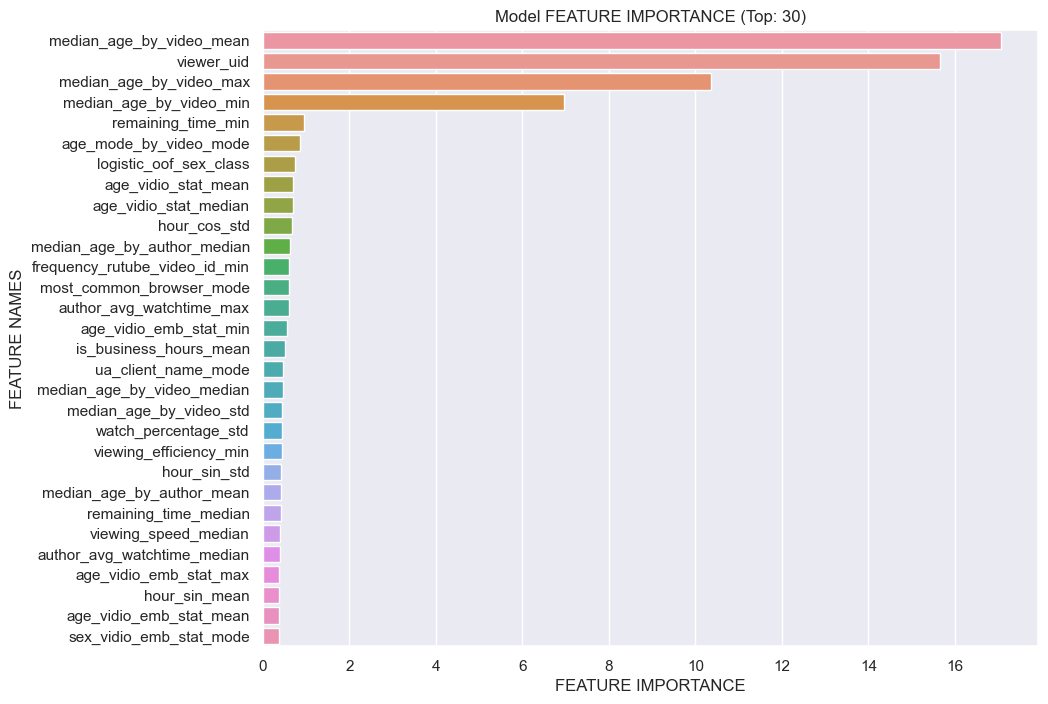

CPU times: total: 6min 15s
Wall time: 4min 27s


((155117, 580), (17227, 580), (555018, 577))

In [96]:
%%time
# Генерируем фичи через кроссвалидацию (Out-of-fold OOF)
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

from sklearn.utils.class_weight import compute_class_weight
from typing import List

def calc_cv_target(train_df:pd.DataFrame, test_df:pd.DataFrame, submit_df:pd.DataFrame, features_columns:List[str], category_features:List[str],  target_col:str, iterations:int=1000):
    X = train_df[features_columns]
    y = train_df[target_col]
    # Количество фолдов для кросс-валидации
    n_folds = 5
    # Создаем объект StratifiedKFold для кросс-валидации
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=53)
    

    # Создаем массив для хранения OOF предсказаний
    oof_predictions = np.zeros(len(X))
    
    # Проходим по каждому фолду
    for i, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
        print(f'fold: {i+1}')
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        
        # Всегда выделяем данные под валидацию, чтобы бустинг модель могла сделать ранний останов + подбор гиперпараметров
        X_train, X_val, y_train, y_val = train_test_split(
                                    X_train, 
                                    y_train, 
                                    test_size=0.05, 
                                    stratify=y_train,
                                    random_state=53)
        
        fold_cv_model = CatBoostRegressor(iterations=iterations,
                        eval_metric = "MAE", 
                        early_stopping_rounds=200, 
                        ignored_features=ignore_features,
                        cat_features=category_features,
                        random_state=53,
                        task_type="GPU",
                        devices='0',
        #                 learning_rate = 0.1,
                        )        
        # Обучаем модель на данных фолда
        fold_cv_model.fit(X_train, y_train,
                  eval_set=(X_val, y_val), 
                  plot=True, 
                  verbose=False,
                 )
        train_df.loc[valid_idx, f'cv_predict_{target_col}'] = fold_cv_model.predict(X_valid)
    print('Предсказание для тестовых данных')
    # Делаем предсказание для тестовых данных
    X_train, X_val, y_train, y_val = train_test_split(
                                X, 
                                y, 
                                test_size=0.05, 
                                stratify=y,
                                random_state=53)
    
    fold_cv_model = CatBoostRegressor(iterations=iterations,
                    eval_metric = "MAE", 
                    early_stopping_rounds=200, 
                    ignored_features=ignore_features,
                    cat_features=category_features,
                    random_state=53,
                    task_type="GPU",
                    devices='0',
    #                 learning_rate = 0.1,
                    )        
    # Обучаем модель на данных фолда
    fold_cv_model.fit(X_train, y_train,
              eval_set=(X_val, y_val), 
              plot=True, 
              verbose=False,
             )
    test_df[f'cv_predict_{target_col}'] = fold_cv_model.predict(test_df[features_columns])
    
    submit_df[f'cv_predict_{target_col}'] = fold_cv_model.predict(submit_df[features_columns])
    
    plot_feature_importance(fold_cv_model.get_feature_importance(), (fold_cv_model.feature_names_),f'Model', top_n=30)
    plt.show()
    
    return train_df, test_df, submit_df

oof_agg_train_users_df, oof_agg_test_users_df, oof_agg_submit_test_users_df = calc_cv_target(
                oof_agg_train_users_df, 
                oof_agg_test_users_df, 
                oof_agg_submit_test_users_df,
                features_columns=features_columns,
                category_features=category_features,
                target_col='age',
                iterations=1000,)

oof_agg_train_users_df.shape, oof_agg_test_users_df.shape, oof_agg_submit_test_users_df.shape

In [97]:
# 2+3

### Модель классификации по полу и возрасту

fold: 1
(117888, 577) (6205, 577) (117888,) (6205,)
class_weights: [0.97824247 1.02274738]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


fold: 2
(117888, 577) (6205, 577) (117888,) (6205,)
class_weights: [0.97824247 1.02274738]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


fold: 3
(117889, 577) (6205, 577) (117889,) (6205,)
class_weights: [0.97825077 1.02273831]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


fold: 4
(117889, 577) (6205, 577) (117889,) (6205,)
class_weights: [0.97825077 1.02273831]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


fold: 5
(117889, 577) (6205, 577) (117889,) (6205,)
class_weights: [0.97823453 1.02275606]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


Предсказание для тестовых данных
(147361, 577) (7756, 577) (147361,) (7756,)
class_weights: [0.97823287 1.02275787]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


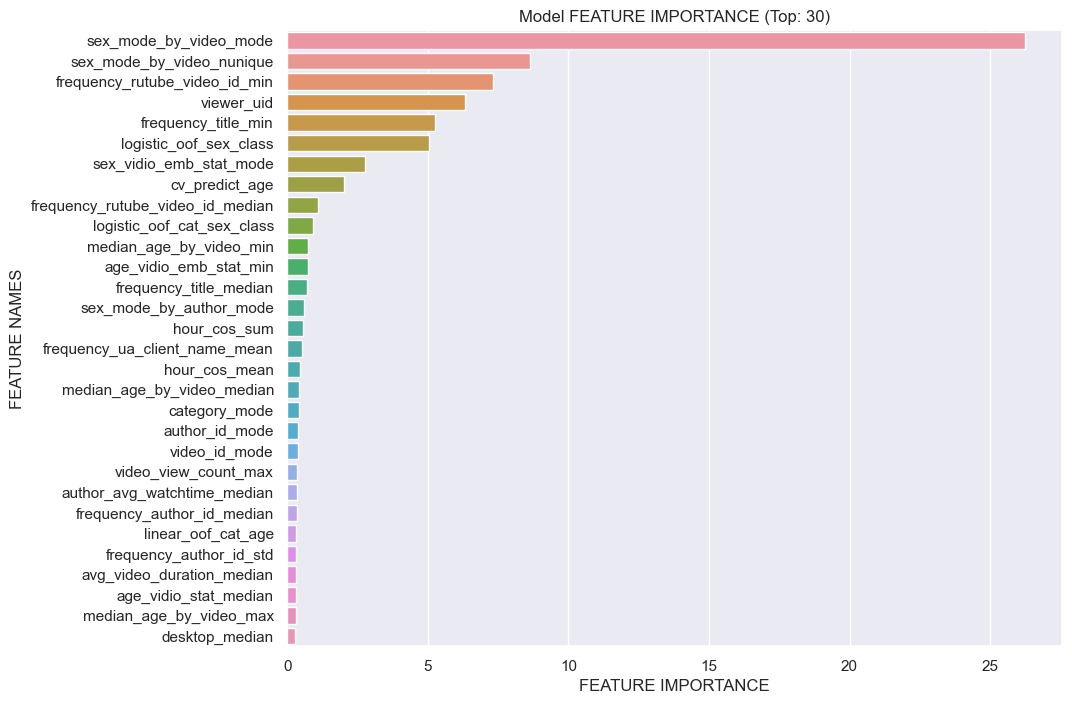

CPU times: total: 6min 50s
Wall time: 4min 50s


((155117, 582), (17227, 582), (555018, 579))

In [98]:
%%time
# Генерируем фичи через кроссвалидацию (Out-of-fold OOF)
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

from sklearn.utils.class_weight import compute_class_weight
from typing import List

def calc_cv_target(train_df:pd.DataFrame, test_df:pd.DataFrame, submit_df:pd.DataFrame, features_columns:List[str], category_features:List[str],  target_col:str, iterations:int=1000):
    X = train_df[features_columns]
    y = train_df[target_col]
    
    # Количество фолдов для кросс-валидации
    n_folds = 5
    # Создаем объект StratifiedKFold для кросс-валидации
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=53)
    

    # Создаем массив для хранения OOF предсказаний
    oof_predictions = np.zeros(len(X))
    

    # plot_feature_importance(model_by_cat_level_zero.get_feature_importance(), (features_columns_one_model ),f'Zero Model', top_n=50)
    # plt.show()
    # Проходим по каждому фолду
    for i, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
        print(f'fold: {i+1}')
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        
        # Всегда выделяем данные под валидацию, чтобы бустинг модель могла сделать ранний останов + подбор гиперпараметров
        X_train, X_val, y_train, y_val = train_test_split(
                                    X_train, 
                                    y_train, 
                                    test_size=0.05, 
                                    stratify=y_train,
                                    random_state=53)
        print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
        # Определяем уникальные классы
        classes = np.array(sorted(set(y_train.values)))
        # # Рассчитываем веса для каждого класса
        class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
        print(f'class_weights: {class_weights}')
        fold_cv_model = CatBoostClassifier(iterations=iterations,
                        eval_metric = "AUC", 
                        early_stopping_rounds=200, 
                        ignored_features=ignore_features,
                        cat_features=category_features,
                        random_state=53,
                        task_type="GPU",
                        devices='0',
#                         class_weights=class_weights,
        #                 learning_rate = 0.1,
                        )        
        # Обучаем модель на данных фолда
        fold_cv_model.fit(X_train, y_train,
                  eval_set=(X_val, y_val), 
                  plot=True, 
                  verbose=False,
                 )
        
        train_df.loc[valid_idx, f'cv_predict_{target_col}'] = fold_cv_model.predict(X_valid)
        if len(set(y_train.values)) == 2:
            train_df.loc[valid_idx, f'cv_predict_proba_{target_col}'] = fold_cv_model.predict_proba(X_valid)[:,1]
    print('Предсказание для тестовых данных')
    # Делаем предсказание для тестовых данных
    X_train, X_val, y_train, y_val = train_test_split(
                                X, 
                                y, 
                                test_size=0.05, 
                                stratify=y,
                                random_state=53)
    print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
    # Определяем уникальные классы
    classes = np.array(sorted(set(y_train.values)))
    # # Рассчитываем веса для каждого класса
    class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
    print(f'class_weights: {class_weights}')
    fold_cv_model = CatBoostClassifier(iterations=iterations,
                    eval_metric = "AUC", 
                    early_stopping_rounds=200, 
                    ignored_features=ignore_features,
                    cat_features=category_features,
                    random_state=53,
                    task_type="GPU",
                    devices='0',
#                     class_weights=class_weights,
    #                 learning_rate = 0.1,
                    )        
    # Обучаем модель на данных фолда
    fold_cv_model.fit(X_train, y_train,
              eval_set=(X_val, y_val), 
              plot=True, 
              verbose=False,
             )
    test_df[f'cv_predict_{target_col}'] = fold_cv_model.predict(test_df[features_columns])
    submit_df[f'cv_predict_{target_col}'] = fold_cv_model.predict(submit_df[features_columns])
    
    if len(set(y_train.values)) == 2:
        test_df[f'cv_predict_proba_{target_col}'] = fold_cv_model.predict_proba(test_df[features_columns])[:,1]
        submit_df[f'cv_predict_proba_{target_col}'] = fold_cv_model.predict_proba(submit_df[features_columns])[:,1]
        
    plot_feature_importance(fold_cv_model.get_feature_importance(), (fold_cv_model.feature_names_),f'Model', top_n=30)
    plt.show()
    
    return train_df, test_df, submit_df

oof_agg_train_users_df, oof_agg_test_users_df, oof_agg_submit_test_users_df = calc_cv_target(
                oof_agg_train_users_df, 
                oof_agg_test_users_df, 
                oof_agg_submit_test_users_df,
                features_columns=features_columns + ['cv_predict_age'],
                category_features=category_features,
                target_col='sex',
                iterations=1000)

oof_agg_train_users_df.shape, oof_agg_test_users_df.shape, oof_agg_submit_test_users_df.shape

fold: 1
(117888, 579) (6205, 579) (117888,) (6205,)
class_weights: [5.98659354 0.70459979 0.68461521 1.04927371]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


fold: 2
(117888, 579) (6205, 579) (117888,) (6205,)
class_weights: [5.98659354 0.70459979 0.68461521 1.04927371]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


fold: 3
(117889, 579) (6205, 579) (117889,) (6205,)
class_weights: [5.98542851 0.70462261 0.68462101 1.04924526]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


fold: 4
(117889, 579) (6205, 579) (117889,) (6205,)
class_weights: [5.98542851 0.70462261 0.68462101 1.04924526]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


fold: 5
(117889, 579) (6205, 579) (117889,) (6205,)
class_weights: [5.98664432 0.70460577 0.68460511 1.04928261]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


Предсказание для тестовых данных
(147361, 579) (7756, 579) (147361,) (7756,)
class_weights: [5.98639097 0.70460457 0.68461031 1.04928083]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


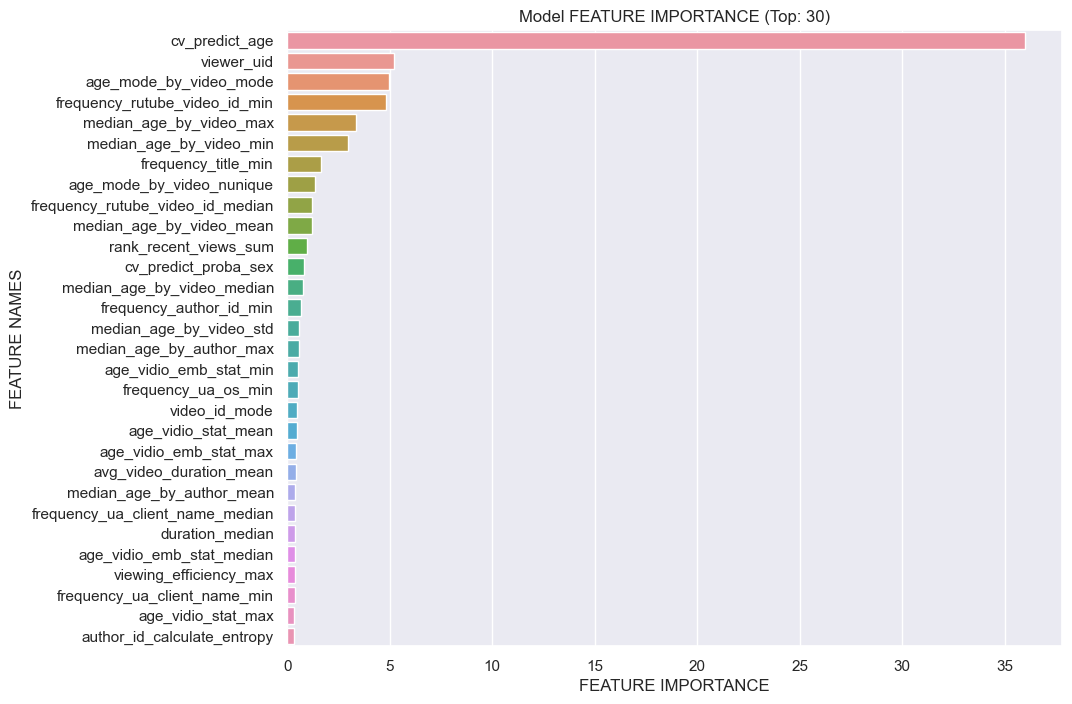

((155117, 583), (17227, 583), (555018, 580))

In [99]:
oof_agg_train_users_df, oof_agg_test_users_df, oof_agg_submit_test_users_df = calc_cv_target(
                oof_agg_train_users_df, 
                oof_agg_test_users_df, 
                oof_agg_submit_test_users_df,
                features_columns=features_columns + ['cv_predict_age', 'cv_predict_sex', 'cv_predict_proba_sex'],
                category_features=category_features + ['cv_predict_sex'],
                target_col='age_class')

oof_agg_train_users_df.shape, oof_agg_test_users_df.shape, oof_agg_submit_test_users_df.shape

# Модель по полу

In [102]:
# bad_client = np.array(tmp_gr_size[tmp_gr_size <= 0].index)
# len(bad_client)

In [203]:
# Всегда выделяем данные под валидацию, чтобы бустинг модель могла сделать ранний останов + подбор гиперпараметров
X_train, X_val, y_train, y_val = train_test_split(
                                oof_agg_train_users_df[features_columns + ['cv_predict_age', 'cv_predict_sex', 'cv_predict_proba_sex', 'cv_predict_age_class']], 
                                oof_agg_train_users_df['sex'], 
                                test_size=0.05, 
                                random_state=53)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((147361, 580), (7756, 580), (147361,), (7756,))

In [204]:

# # Всегда выделяем данные под валидацию, чтобы бустинг модель могла сделать ранний останов + подбор гиперпараметров
# X_train, X_val, y_train, y_val = train_test_split(
#                                 oof_agg_train_users_df[~oof_agg_train_users_df['viewer_uid'].isin(bad_client)][features_columns + ['cv_predict_age', 'cv_predict_sex', 'cv_predict_proba_sex', 'cv_predict_age_class']], 
#                                 oof_agg_train_users_df[~oof_agg_train_users_df['viewer_uid'].isin(bad_client)]['sex'], 
#                                 test_size=0.05, 
#                                 random_state=53)

# X_train.shape, X_val.shape, y_train.shape, y_val.shape

In [205]:
# # Определяем уникальные классы
# classes = np.array(sorted(set(y_train.values)))
# # # Рассчитываем веса для каждого класса
# class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
# print(f'class_weights: {class_weights}')

In [206]:
# union_for_submit = pd.concat([oof_agg_train_users_df, oof_agg_test_users_df])
# # Всегда выделяем данные под валидацию, чтобы бустинг модель могла сделать ранний останов + подбор гиперпараметров
# X_train, X_val, y_train, y_val = train_test_split(
#                                 union_for_submit[features_columns + ['cv_predict_age', 'cv_predict_sex', 'cv_predict_proba_sex', 'cv_predict_age_class']], 
#                                 union_for_submit['sex'], 
#                                 test_size=0.05, 
#                                 random_state=53)

# X_train.shape, X_val.shape, y_train.shape, y_val.shape

In [211]:
%%time
# 0.8743853569
# 0.8743678331
sex_model = CatBoostClassifier(iterations=5000,
#                 eval_metric = "AUC", 
                eval_metric = "TotalF1", 
                early_stopping_rounds=200, 
                ignored_features=ignore_features,
                cat_features=category_features + ['cv_predict_sex'],
                # od_type = "Iter",
                # od_wait = 200,                               
                random_state=53,
                task_type="GPU",
                devices='0',
#                 learning_rate = 0.1,
#                 class_weights=class_weights,
                )
# Обучаем модель
sex_model.fit(X_train, y_train,
          eval_set=(X_val, y_val), 
          plot=True, 
          verbose=False,
#           sample_weight = zero_X_train_df['sample_weights'],
         )
# plot_feature_importance(model_by_cat_level_zero.get_feature_importance(), (features_columns_one_model ),f'Zero Model', top_n=50)
# plt.show()


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: total: 31.6 s
Wall time: 21.1 s


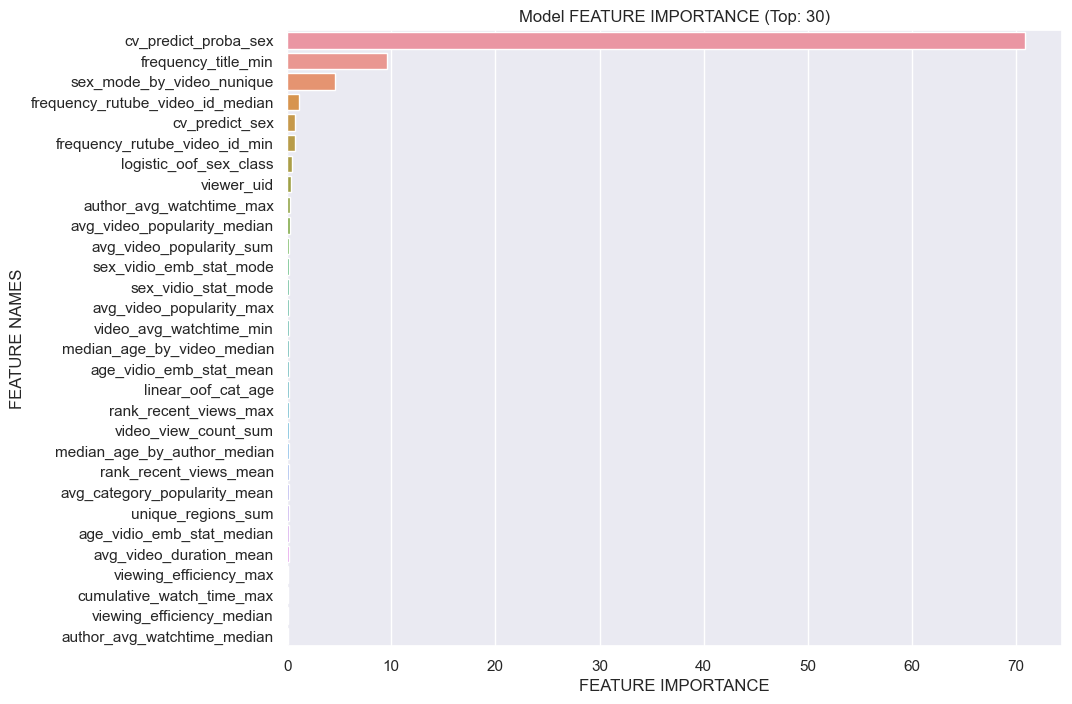

In [107]:
plot_feature_importance(sex_model.get_feature_importance(), (sex_model.feature_names_),f'Model', top_n=30)
plt.show()


# Модель по возрасту (Классификация)

In [212]:
# Всегда выделяем данные под валидацию, чтобы бустинг модель могла сделать ранний останов + подбор гиперпараметров
X_train, X_val, y_train, y_val = train_test_split(
                                oof_agg_train_users_df[features_columns + ['cv_predict_age', 'cv_predict_sex', 'cv_predict_proba_sex', 'cv_predict_age_class']], 
                                oof_agg_train_users_df['age_class'], 
                                test_size=0.05, 
                                random_state=53)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((147361, 580), (7756, 580), (147361,), (7756,))

In [202]:
# union_for_submit = pd.concat([oof_agg_train_users_df, oof_agg_test_users_df])
# # Всегда выделяем данные под валидацию, чтобы бустинг модель могла сделать ранний останов + подбор гиперпараметров
# X_train, X_val, y_train, y_val = train_test_split(
#                                 union_for_submit[features_columns + ['cv_predict_age', 'cv_predict_sex', 'cv_predict_proba_sex', 'cv_predict_age_class']], 
#                                 union_for_submit['age_class'], 
#                                 test_size=0.05, 
#                                 random_state=53)

# X_train.shape, X_val.shape, y_train.shape, y_val.shape


In [213]:
%%time
# 0.84528045
# 0.8435153
# 0.84483157
# 0.84483157
# 0.84712152
# 0.8574841
# 0.86434165
model_age_group = CatBoostClassifier(iterations=5000,
                eval_metric = "TotalF1", 
#                 eval_metric = "AUC", 
                early_stopping_rounds=200, 
                ignored_features=ignore_features,
                cat_features=category_features + ['cv_predict_sex'],
                # od_type = "Iter",
                # od_wait = 200,                               
                random_state=53,
                task_type="GPU",
                devices='0',
#                 learning_rate = 0.1,
                loss_function='MultiClass',
#                 loss_function='MultiClass'
#                 class_weights=class_weights,
                )
# Обучаем модель
model_age_group.fit(X_train, y_train,
          eval_set=(X_val, y_val), 
          plot=True, 
          verbose=False,
#           sample_weight = zero_X_train_df['sample_weights'],
         )


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: total: 25.5 s
Wall time: 10.8 s


In [214]:
# threshold = 0.5
# sex_class_predict_proba = model.predict_proba(agg_test_users_df[model.feature_names_])
# sex_class_predict = np.where(sex_class_predict_proba[:,1] >= threshold, 'male', 'female')
sex_class_predict = sex_model.predict(oof_agg_test_users_df[sex_model.feature_names_])
sex_class_target = oof_agg_test_users_df['sex'].values

age_class_predict = model_age_group.predict(oof_agg_test_users_df[model_age_group.feature_names_] )
# age_class_predict = ages_combine_df['predicted_class'].values
age_class_target = oof_agg_test_users_df['age_class'].values

In [215]:
# Взвешенный классы class_weights
f1_weighted = f1_score(age_class_target, age_class_predict, average='weighted')
accuracy = accuracy_score(sex_class_target, sex_class_predict)

final_score = 0.7 * f1_weighted + 0.3 * accuracy
print(f'Weighted F1 = {f1_weighted:.4f} \nAccuracy = {accuracy:.4f} \nFinal Score = {final_score:.4f}')

Weighted F1 = 0.4939 
Accuracy = 0.7565 
Final Score = 0.5727


In [111]:
# Взвешенный классы class_weights
f1_weighted = f1_score(age_class_target, age_class_predict, average='weighted')
accuracy = accuracy_score(sex_class_target, sex_class_predict)

final_score = 0.7 * f1_weighted + 0.3 * accuracy
print(f'Weighted F1 = {f1_weighted:.4f} \nAccuracy = {accuracy:.4f} \nFinal Score = {final_score:.4f}')

Weighted F1 = 0.4937 
Accuracy = 0.7561 
Final Score = 0.5725


In [139]:
# Взвешенный классы class_weights
f1_weighted = f1_score(age_class_target, age_class_predict, average='weighted')
accuracy = accuracy_score(sex_class_target, sex_class_predict)

final_score = 0.7 * f1_weighted + 0.3 * accuracy
print(f'Weighted F1 = {f1_weighted:.4f} \nAccuracy = {accuracy:.4f} \nFinal Score = {final_score:.4f}')

Weighted F1 = 0.4907 
Accuracy = 0.7661 
Final Score = 0.5733


# Модель по возрсту (Регрессия)

In [112]:
# Всегда выделяем данные под валидацию, чтобы бустинг модель могла сделать ранний останов + подбор гиперпараметров
X_train, X_val, y_train, y_val = train_test_split(
                                oof_agg_train_users_df[features_columns + ['cv_predict_age', 'cv_predict_sex', 'cv_predict_proba_sex', 'cv_predict_age_class']], 
                                oof_agg_train_users_df['age'], 
                                test_size=0.05, 
                                random_state=53)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((147361, 580), (7756, 580), (147361,), (7756,))

In [ ]:
union_for_submit = pd.concat([oof_agg_train_users_df, oof_agg_test_users_df])
# Всегда выделяем данные под валидацию, чтобы бустинг модель могла сделать ранний останов + подбор гиперпараметров
X_train, X_val, y_train, y_val = train_test_split(
                                union_for_submit[features_columns + ['cv_predict_age', 'cv_predict_sex', 'cv_predict_proba_sex', 'cv_predict_age_class']], 
                                union_for_submit['age_class'], 
                                test_size=0.05, 
                                random_state=53)

X_train.shape, X_val.shape, y_train.shape, y_val.shape


In [114]:
from catboost import CatBoostRegressor

model_age_regr = CatBoostRegressor(
                iterations=5000,
                loss_function = "RMSE", 
                early_stopping_rounds=200, 
                ignored_features=ignore_features,
                cat_features=category_features + ['cv_predict_sex'],
                # od_type = "Iter",
                # od_wait = 200,                               
                random_state=53,
                task_type="GPU",
                devices='0',
                # learning_rate = 0.1,
#                 loss_function='MultiClass'
#                 loss_function='MultiClass'
                )
# Обучаем модель
model_age_regr.fit(X_train, y_train,
          eval_set=(X_val, y_val), 
          plot=True, 
          verbose=False,
#           sample_weight = zero_X_train_df['sample_weights'],
         )



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [122]:
# oof_agg_submit_test_users_df.shape


,viewer_uid,predict_sex,predict_age,predict_age_class
0,0,male,44,3
9,1,male,40,3
10,2,male,32,2
12,3,male,40,2
16,4,male,34,2
...,...,...,...,...
555006,59999,male,38,2
555011,60000,female,39,3
555013,60001,male,42,3
555014,60002,male,37,2


In [216]:
oof_agg_submit_test_users_df_predict = oof_agg_submit_test_users_df.copy()
oof_agg_submit_test_users_df_predict['predict_sex'] = sex_model.predict(oof_agg_submit_test_users_df[sex_model.feature_names_])
oof_agg_submit_test_users_df_predict['predict_age'] = model_age_regr.predict(oof_agg_submit_test_users_df_predict[model_age_regr.feature_names_] )
oof_agg_submit_test_users_df_predict['predict_age'] = oof_agg_submit_test_users_df_predict['predict_age'].astype(int)
oof_agg_submit_test_users_df_predict['predict_age_class'] = model_age_group.predict(oof_agg_submit_test_users_df_predict[model_age_group.feature_names_] )
oof_agg_submit_test_users_df_predict[['viewer_uid', 'predict_sex', 'predict_age', 'predict_age_class']]
oof_agg_submit_test_users_df_predict = oof_agg_submit_test_users_df_predict[['viewer_uid', 'predict_sex', 'predict_age', 'predict_age_class']].drop_duplicates()

In [134]:
fill_empty_submit = pd.read_csv('test_dataset/test_events.csv')
# oof_agg_submit_test_users_df_predict
fill_empty_submit = fill_empty_submit[['viewer_uid']].drop_duplicates()
fill_empty_submit = fill_empty_submit.merge(oof_agg_submit_test_users_df_predict, on='viewer_uid', how='left')
fill_empty_submit['predict_sex'] = fill_empty_submit['predict_sex'].fillna('male')
fill_empty_submit['predict_age'] = fill_empty_submit['predict_age'].fillna(38)
fill_empty_submit['predict_age_class'] = fill_empty_submit['predict_age_class'].fillna(2)

fill_empty_submit.shape

(60004, 4)

In [139]:
oof_agg_submit_test_users_df_predict = fill_empty_submit

In [217]:
submission = pd.DataFrame(columns=['viewer_uid', 'sex', 'age_class'])
submission['viewer_uid'] = oof_agg_submit_test_users_df_predict['viewer_uid'].values
submission['age'] = oof_agg_submit_test_users_df_predict['predict_age'].values
submission['sex'] = oof_agg_submit_test_users_df_predict['predict_sex'].values
submission['age_class'] = oof_agg_submit_test_users_df_predict['predict_age_class'].values
submission.shape


(57032, 4)

In [219]:
submission_filename = 'submission/submission_v4.csv'
submission.to_csv(
    submission_filename, index=False 
)

In [126]:
# oof_agg_submit_test_users_df_predict.shape

In [764]:
# Взвешенный классы class_weights
f1_weighted = f1_score(age_class_target, age_class_predict, average='weighted')
accuracy = accuracy_score(sex_class_target, sex_class_predict)

final_score = 0.7 * f1_weighted + 0.3 * accuracy
print(f'Weighted F1 = {f1_weighted:.4f} \nAccuracy = {accuracy:.4f} \nFinal Score = {final_score:.4f}')

Weighted F1 = 0.4775 
Accuracy = 0.7579 
Final Score = 0.5616


In [743]:
# Взвешенный классы class_weights
f1_weighted = f1_score(age_class_target, age_class_predict, average='weighted')
accuracy = accuracy_score(sex_class_target, sex_class_predict)

final_score = 0.7 * f1_weighted + 0.3 * accuracy
print(f'Weighted F1 = {f1_weighted:.4f} \nAccuracy = {accuracy:.4f} \nFinal Score = {final_score:.4f}')

Weighted F1 = 0.4821 
Accuracy = 0.7596 
Final Score = 0.5653


In [679]:
# Взвешенный классы class_weights
f1_weighted = f1_score(age_class_target, age_class_predict, average='weighted')
accuracy = accuracy_score(sex_class_target, sex_class_predict)

final_score = 0.7 * f1_weighted + 0.3 * accuracy
print(f'Weighted F1 = {f1_weighted:.4f} \nAccuracy = {accuracy:.4f} \nFinal Score = {final_score:.4f}')

Weighted F1 = 0.4885 
Accuracy = 0.7623 
Final Score = 0.5706


In [634]:
# Взвешенный классы class_weights
f1_weighted = f1_score(age_class_target, age_class_predict, average='weighted')
accuracy = accuracy_score(sex_class_target, sex_class_predict)

final_score = 0.7 * f1_weighted + 0.3 * accuracy
print(f'Weighted F1 = {f1_weighted:.4f} \nAccuracy = {accuracy:.4f} \nFinal Score = {final_score:.4f}')

Weighted F1 = 0.4869 
Accuracy = 0.7624 
Final Score = 0.5696


In [574]:
# Взвешенный классы class_weights
f1_weighted = f1_score(age_class_target, age_class_predict, average='weighted')
accuracy = accuracy_score(sex_class_target, sex_class_predict)

final_score = 0.7 * f1_weighted + 0.3 * accuracy
print(f'Weighted F1 = {f1_weighted:.4f} \nAccuracy = {accuracy:.4f} \nFinal Score = {final_score:.4f}')

Weighted F1 = 0.4879 
Accuracy = 0.7616 
Final Score = 0.5700


In [528]:
# Взвешенный классы class_weights
f1_weighted = f1_score(age_class_target, age_class_predict, average='weighted')
accuracy = accuracy_score(sex_class_target, sex_class_predict)

final_score = 0.7 * f1_weighted + 0.3 * accuracy
print(f'Weighted F1 = {f1_weighted:.4f} \nAccuracy = {accuracy:.4f} \nFinal Score = {final_score:.4f}')

Weighted F1 = 0.4829 
Accuracy = 0.7616 
Final Score = 0.5665


video_id_nunique


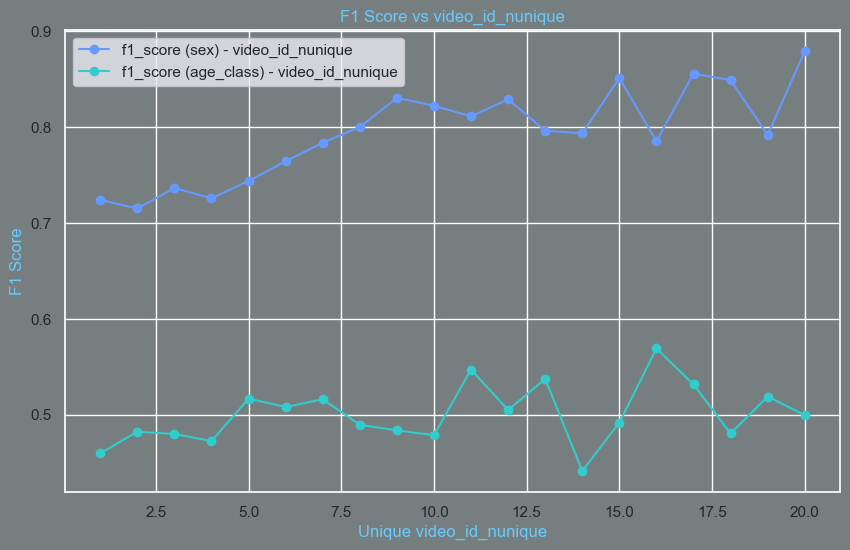

In [658]:
predict_sex = sex_model.predict(oof_agg_test_users_df[features_columns + ['cv_predict_age', 'cv_predict_sex', 'cv_predict_proba_sex', 'cv_predict_age_class']])
predict_age_class = model_age_group.predict(oof_agg_test_users_df[features_columns + ['cv_predict_age', 'cv_predict_sex', 'cv_predict_proba_sex', 'cv_predict_age_class']])


count_columns = ['video_id_nunique', 'author_id_nunique', 'day_name_nunique',
          'category_mode', 'duration_category_mode',
            'frequency_author_id_mean','sex', 'age_class'
]

test_users = oof_agg_test_users_df[count_columns].copy()  # Make a copy to avoid the warning

# Use .loc to set the values
test_users.loc[:, 'predict_sex'] = predict_sex
test_users.loc[:, 'predict_age_class'] = predict_age_class


# Список колонок, по которым будем строить графики
columns = [
    'video_id_nunique', #'author_id_nunique', 
    # # 'day_name_nunique',
    # # 'category_mode', #'duration_category_mode',
           ]

# Цикл по каждой колонке
for col in columns:
    print(col)
    # Группировка данных по текущей колонке
    grouped = test_users.groupby(col)
    
    # Списки для хранения результатов
    unique_values = []
    sex_accuracy = []
    age_accuracy = []
    
#     # Цикл по каждой группе
#     for value, group in grouped:
#         # Сохраним текущее значение уникального признака
#         unique_values.append(value)
        
#         # Вычислим F1-score для sex
#         sex_acc = f1_score(group['sex'], group['predict_sex'], average='weighted')
#         sex_accuracy.append(sex_acc)
        
#         # Вычислим F1-score для age_class
#         age_acc = f1_score(group['age_class'], group['predict_age_class'], average='weighted')
#         age_accuracy.append(age_acc)
    
    count=0
    # Цикл по каждой группе
    for value, group in grouped:
        # Сохраним текущее значение уникального признака
        unique_values.append(value)
        
        # Вычислим F1-score для sex
        sex_acc = f1_score(group['sex'], group['predict_sex'], average='weighted')
        sex_accuracy.append(sex_acc)
        
        # Вычислим F1-score для age_class
        age_acc = f1_score(group['age_class'], group['predict_age_class'], average='weighted')
        age_accuracy.append(age_acc)
        count += 1
        if count == 20:
            break
            
    # Построение графиков
    fig, ax = plt.subplots(figsize=(10, 6))

    # Установка фона графика в холодный серый цвет
    plt.gcf().set_facecolor('#777e7f')  # Светло-серый цвет фона
    # Установка фона самого поля графика в холодный серый цвет
    ax.set_facecolor('#777e7f')  # Более темный серый для области внутри осей    
    # График для точности по полу (sex)
#     plt.plot(unique_values, sex_accuracy, label=f'f1_score (sex) - {col}', marker='o', color='red')
    plt.plot(unique_values, sex_accuracy, label=f'f1_score (sex) - {col}', marker='o', color='#6699ff')
    
    
    # График для точности по возрастной группе (age_class)
    plt.plot(unique_values, age_accuracy, label=f'f1_score (age_class) - {col}', marker='o', color='#33cccc')
    
    # Настройки графика
#     r'\textcolor{red}{Today} '
#     plt.xlabel(r'\textcolor{red}{col}')
    plt.xlabel(f'Unique {col}').set_color("#66ccff")
    plt.ylabel('F1 Score').set_color("#66ccff")
    plt.title(f'F1 Score vs {col}').set_color("#66ccff")
    plt.legend()
    plt.grid(True)
    
    # Показать график
    plt.show()
